In [1]:
import imageio
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout, AveragePooling2D, Flatten, Dropout, LSTM, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import tensorflow as tf

In [14]:
def preprocess_imagery(path):
    '''
    Pre process satellite imagery. We check for nans in the composite images,
    and then we load them into the [0,1] range.
    Input: TIF files downloaded from GEE (224x224x7)
    '''
    # Reading image
    path = str(path).strip('b').strip("'")
    path="./GEE_Images/GEE_Images/"+path+".tif"
    image = (imageio.imread(path))
    """if np.sum(np.isnan(image)) > 0:
        # Taking the mean of the image, per channel
        mean = np.nanmean(image, axis=(0, 1))
        # Replacing NaN with per channel mean
        replacement = np.isnan(image) * mean
        image[np.isnan(image)] = replacement[np.isnan(image)]  
        nan_channels = np.all(np.isnan(image), axis=(0, 1))
        # Replacing NaN with 0 where all values in a channel are NaN
        image[:, :, nan_channels] = np.nan_to_num(image[:, :, nan_channels])
    # Scale the image to [0, 1] range
    image = image / 255"""
    return image

In [15]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping: no known devices.


In [17]:
image_files = [f for f in os.listdir("../GEE_Images/GEE_Images")]
image_info = []
#df = pd.read_csv('processed_data.csv')
"""
for image in image_files:
    name, _ = os.path.splitext(image)
    # Extraer estación y fecha de las imágenes
    station = '_'.join(name.split(' ')[0].split('_')[:-1])
    date = name.split(' ')[0].split('_')[-1]
    image_info.append([station, date,name])

# Añadimos una columna para asociar imágenes en df
df['image'] = None  # Inicialmente sin imágenes asociadas

# Ahora asociamos cada imagen a su registro en df
for info in image_info:
    df.loc[(df['station'] == info[0]) & (df['Date'] == info[1]), 'image'] = info[2]
"""
# Verificar que las imágenes se han asignado correctamente
df=pd.read_csv('dataframe_final.csv')

In [18]:
# Definir la métrica personalizada SMAPE
def smape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()  # Pequeño valor para evitar divisiones por cero
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + epsilon
    diff = tf.abs(y_true - y_pred) / denominator
    return 100.0 * tf.reduce_mean(diff)  # Se devuelve el error en porcentaje


In [19]:
def smape_2(y_true, y_pred):
    """
    Calcula el Symmetric Mean Absolute Percentage Error.
    """
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))

In [20]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)


In [21]:
df_Scaled=df.copy()
# Crear un diccionario para almacenar los datos de cada locación
df_Scaled.fillna(value=0,inplace=True)
grouped_data = {location: location_df.sort_values(by='Date') for location, location_df in df_Scaled.groupby('station')}

In [22]:
df['image'].describe()

count                             51782
unique                            51782
top       El_bosque_1997-07-01 00_00_00
freq                                  1
Name: image, dtype: object

### Usando 7 días previos para predecir el día siguiente (Sin capping)

In [23]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [11]:


# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model.summary()


I0000 00:00:1729569939.506586    1017 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729569939.506687    1017 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729569939.506736    1017 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729569939.506905    1017 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729569939.506952    1017 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        880 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 12, 12,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    589,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 50)     │     13,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     20,200 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     22,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [13]:
X_train[0].shape

(7, 17)

In [14]:
checkpoint_path = "training/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [15]:
history=model.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)

Epoch 1/50


/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_12']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))
2024-10-22 01:05:43.482034: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729569943.581490    1156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729569943.673599    1156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729569943.675382    1156 gpu_timer.cc:114] Skippin

   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:45:46 4s/step - loss: 3.3482 - mean_absolute_percentage_error: 6740.0093 - mean_squared_error: 21.7092 - smape: 181.2576

W0000 00:00:1729569944.996960    1155 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729569944.998544    1155 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729569945.000563    1155 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729569945.008533    1155 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729569945.009545    1155 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729569945.011007    1155 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729569945.012433    1155 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729569945.013908    1155 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729569945.015138    1155 gp

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0650 - mean_absolute_percentage_error: 63300.4648 - mean_squared_error: 0.2238 - smape: 53.0091

W0000 00:00:1729570335.103314    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570335.182717    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570335.195306    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570335.221639    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570335.236606    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570335.249045    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570335.314544    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570335.349737    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570335.394366    1161 gp


Epoch 1: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 456s 201ms/step - loss: 0.0650 - mean_absolute_percentage_error: 63303.3867 - mean_squared_error: 0.2237 - smape: 53.0073 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 94653.2422 - val_mean_squared_error: 9.2085e-04 - val_smape: 46.6510
Epoch 2/50


W0000 00:00:1729570397.094427    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.103383    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.109499    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.116052    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.120530    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.126445    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.132839    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.138933    1161 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.146456    1161 gp

   1/2253 ━━━━━━━━━━━━━━━━━━━━ 26:46 713ms/step - loss: 0.0147 - mean_absolute_percentage_error: 23.7763 - mean_squared_error: 3.2328e-04 - smape: 40.7073

W0000 00:00:1729570397.717313    1157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.718310    1157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.719400    1157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.720618    1157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.721795    1157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.723156    1157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.724515    1157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.725841    1157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.727048    1157 gp


Epoch 2: saving model to training/ckpt.weights.h5


W0000 00:00:1729570397.920575    1156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.925120    1156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.927683    1156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.930421    1156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.946956    1156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.947868    1156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.948729    1156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.949524    1156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729570397.950518    1156 gp

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1s 174us/step - loss: 0.0147 - mean_absolute_percentage_error: 23.7763 - mean_squared_error: 3.2328e-04 - smape: 20.3627 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 39.2444 - val_mean_squared_error: 5.9057e-04 - val_smape: 19.2102
Epoch 3/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0185 - mean_absolute_percentage_error: 59727.0820 - mean_squared_error: 8.3494e-04 - smape: 48.8441
Epoch 3: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 469s 208ms/step - loss: 0.0185 - mean_absolute_percentage_error: 59730.9492 - mean_squared_error: 8.3493e-04 - smape: 48.8442 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 87945.0547 - val_mean_squared_error: 8.0766e-04 - val_smape: 49.4623
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 4:09 111ms/step - loss: 0.0111 - mean_absolute_percentage_error: 18.7281 - mean_squared_error: 2.1098e-04 - smape: 43.0345
Epoch 4: saving model to training/ckpt.weights.h5


2024-10-22 01:21:06.941724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 01:21:06.942649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 01:21:06.942673: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 01:21:06.942681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 01:21:06.942834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 01:21:06.942848: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 01:21:06.942871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 118us/step - loss: 0.0111 - mean_absolute_percentage_error: 18.7281 - mean_squared_error: 2.1098e-04 - smape: 21.5268 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 37.6185 - val_mean_squared_error: 5.3849e-04 - val_smape: 19.8489
Epoch 5/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0176 - mean_absolute_percentage_error: 57752.0820 - mean_squared_error: 7.5268e-04 - smape: 49.4614
Epoch 5: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 481s 213ms/step - loss: 0.0176 - mean_absolute_percentage_error: 57756.1406 - mean_squared_error: 7.5267e-04 - smape: 49.4614 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 92792.2891 - val_mean_squared_error: 7.8266e-04 - val_smape: 48.2575
Epoch 6/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 4:15 113ms/step - loss: 0.0116 - mean_absolute_percentage_error: 18.5738 - mean_squared_error: 2.3401e-04 - smape: 41.1077
Epoch 6: saving model to training/ckpt.weights.h5


2024-10-22 01:29:08.468140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 01:29:08.468614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 01:29:08.468836: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 01:29:08.468872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 01:29:08.469087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 01:29:08.469104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 01:29:08.469128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 95us/step - loss: 0.0116 - mean_absolute_percentage_error: 18.5738 - mean_squared_error: 2.3401e-04 - smape: 20.5630 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 39.9323 - val_mean_squared_error: 5.5735e-04 - val_smape: 19.5915
Epoch 7/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0171 - mean_absolute_percentage_error: 58174.6953 - mean_squared_error: 7.2905e-04 - smape: 49.8196
Epoch 7: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 476s 211ms/step - loss: 0.0171 - mean_absolute_percentage_error: 58178.2930 - mean_squared_error: 7.2905e-04 - smape: 49.8197 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 89053.5625 - val_mean_squared_error: 7.8195e-04 - val_smape: 48.0501
Epoch 8/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:42 72ms/step - loss: 0.0122 - mean_absolute_percentage_error: 19.3254 - mean_squared_error: 2.3744e-04 - smape: 41.1859
Epoch 8: saving model to training/ckpt.weights.h5


2024-10-22 01:37:04.421415: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 01:37:04.421827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 01:37:04.422035: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 01:37:04.422062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 01:37:04.422210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 01:37:04.422226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 01:37:04.422391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 117us/step - loss: 0.0122 - mean_absolute_percentage_error: 19.3254 - mean_squared_error: 2.3744e-04 - smape: 20.6021 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 36.5029 - val_mean_squared_error: 4.9410e-04 - val_smape: 19.2716
Epoch 9/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0168 - mean_absolute_percentage_error: 57466.4023 - mean_squared_error: 7.0674e-04 - smape: 50.1937
Epoch 9: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 496s 220ms/step - loss: 0.0168 - mean_absolute_percentage_error: 57469.9453 - mean_squared_error: 7.0673e-04 - smape: 50.1937 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 87096.2266 - val_mean_squared_error: 7.5497e-04 - val_smape: 48.3911
Epoch 10/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:50 76ms/step - loss: 0.0142 - mean_absolute_percentage_error: 22.0299 - mean_squared_error: 3.3312e-04 - smape: 40.8621
Epoch 10: saving model to training/ckpt.weights.h5


2024-10-22 01:45:21.108389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 01:45:21.108664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 01:45:21.108890: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 01:45:21.108907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 01:45:21.109079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 01:45:21.109097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 01:45:21.109120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 107us/step - loss: 0.0142 - mean_absolute_percentage_error: 22.0299 - mean_squared_error: 3.3312e-04 - smape: 20.4401 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 40.0948 - val_mean_squared_error: 5.7454e-04 - val_smape: 19.9110
Epoch 11/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0165 - mean_absolute_percentage_error: 57001.1641 - mean_squared_error: 6.8789e-04 - smape: 50.3934
Epoch 11: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 494s 219ms/step - loss: 0.0165 - mean_absolute_percentage_error: 57004.6133 - mean_squared_error: 6.8789e-04 - smape: 50.3934 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 76822.8125 - val_mean_squared_error: 8.1200e-04 - val_smape: 51.1628
Epoch 12/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:34 68ms/step - loss: 0.0131 - mean_absolute_percentage_error: 19.7925 - mean_squared_error: 2.8314e-04 - smape: 41.1962
Epoch 12: saving model to training/ckpt.weights.h5


2024-10-22 01:53:35.031302: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 01:53:35.031597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 01:53:35.031608: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 01:53:35.031616: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 01:53:35.031769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 01:53:35.031787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 01:53:35.031810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - loss: 0.0131 - mean_absolute_percentage_error: 19.7925 - mean_squared_error: 2.8314e-04 - smape: 20.6073 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 33.7464 - val_mean_squared_error: 4.5255e-04 - val_smape: 19.9657
Epoch 13/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0163 - mean_absolute_percentage_error: 55455.2891 - mean_squared_error: 6.7802e-04 - smape: 50.5318
Epoch 13: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 488s 217ms/step - loss: 0.0163 - mean_absolute_percentage_error: 55459.0820 - mean_squared_error: 6.7801e-04 - smape: 50.5318 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 76256.8594 - val_mean_squared_error: 7.5842e-04 - val_smape: 51.2758
Epoch 14/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:39 71ms/step - loss: 0.0127 - mean_absolute_percentage_error: 20.9504 - mean_squared_error: 2.4201e-04 - smape: 43.5135
Epoch 14: saving model to training/ckpt.weights.h5


2024-10-22 02:01:43.709146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 02:01:43.709740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 02:01:43.709938: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 02:01:43.709949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 02:01:43.710085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 02:01:43.710099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 02:01:43.710176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 106us/step - loss: 0.0127 - mean_absolute_percentage_error: 20.9504 - mean_squared_error: 2.4201e-04 - smape: 21.7664 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 35.6214 - val_mean_squared_error: 5.0977e-04 - val_smape: 20.4499
Epoch 15/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0162 - mean_absolute_percentage_error: 55949.8125 - mean_squared_error: 6.7259e-04 - smape: 50.6132
Epoch 15: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 498s 221ms/step - loss: 0.0162 - mean_absolute_percentage_error: 55952.7188 - mean_squared_error: 6.7258e-04 - smape: 50.6132 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 71552.9375 - val_mean_squared_error: 7.3887e-04 - val_smape: 52.6226
Epoch 16/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:41 72ms/step - loss: 0.0116 - mean_absolute_percentage_error: 18.2767 - mean_squared_error: 2.2972e-04 - smape: 38.9863
Epoch 16: saving model to training/ckpt.weights.h5


2024-10-22 02:10:01.967986: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 02:10:01.968350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 02:10:01.968361: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 02:10:01.968367: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 02:10:01.968519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 02:10:01.968531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 02:10:01.968551: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 110us/step - loss: 0.0116 - mean_absolute_percentage_error: 18.2767 - mean_squared_error: 2.2972e-04 - smape: 19.5018 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 33.4979 - val_mean_squared_error: 4.8869e-04 - val_smape: 21.0641
Epoch 17/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0160 - mean_absolute_percentage_error: 54326.6602 - mean_squared_error: 6.5919e-04 - smape: 50.9093
Epoch 17: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 491s 218ms/step - loss: 0.0160 - mean_absolute_percentage_error: 54329.9609 - mean_squared_error: 6.5918e-04 - smape: 50.9093 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 73334.6328 - val_mean_squared_error: 7.1734e-04 - val_smape: 52.6317
Epoch 18/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:58 79ms/step - loss: 0.0104 - mean_absolute_percentage_error: 17.3857 - mean_squared_error: 1.6701e-04 - smape: 39.7506
Epoch 18: saving model to training/ckpt.weights.h5


2024-10-22 02:18:13.179131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 02:18:13.179385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 02:18:13.179400: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 02:18:13.179412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 02:18:13.179628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 02:18:13.179657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 02:18:13.179858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - loss: 0.0104 - mean_absolute_percentage_error: 17.3857 - mean_squared_error: 1.6701e-04 - smape: 19.8841 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 36.3382 - val_mean_squared_error: 5.4573e-04 - val_smape: 21.2561
Epoch 19/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0159 - mean_absolute_percentage_error: 52938.5195 - mean_squared_error: 6.5222e-04 - smape: 51.0315
Epoch 19: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 485s 215ms/step - loss: 0.0159 - mean_absolute_percentage_error: 52941.1875 - mean_squared_error: 6.5221e-04 - smape: 51.0315 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 71145.2656 - val_mean_squared_error: 7.1111e-04 - val_smape: 52.7423
Epoch 20/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:37 70ms/step - loss: 0.0099 - mean_absolute_percentage_error: 16.7135 - mean_squared_error: 1.3703e-04 - smape: 41.6416
Epoch 20: saving model to training/ckpt.weights.h5


2024-10-22 02:26:18.924479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 02:26:18.925320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 02:26:18.925331: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 02:26:18.925340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 02:26:18.925497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 02:26:18.925511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 02:26:18.925668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 110us/step - loss: 0.0099 - mean_absolute_percentage_error: 16.7135 - mean_squared_error: 1.3703e-04 - smape: 20.8301 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 35.0056 - val_mean_squared_error: 5.3729e-04 - val_smape: 21.1232
Epoch 21/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0158 - mean_absolute_percentage_error: 51074.7344 - mean_squared_error: 6.4933e-04 - smape: 51.1006
Epoch 21: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 482s 214ms/step - loss: 0.0158 - mean_absolute_percentage_error: 51077.6055 - mean_squared_error: 6.4933e-04 - smape: 51.1006 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 63659.1055 - val_mean_squared_error: 7.2954e-04 - val_smape: 53.2288
Epoch 22/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:36 70ms/step - loss: 0.0122 - mean_absolute_percentage_error: 19.9060 - mean_squared_error: 2.5361e-04 - smape: 39.3724
Epoch 22: saving model to training/ckpt.weights.h5


2024-10-22 02:34:21.215052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 02:34:21.215617: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 02:34:21.215638: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 02:34:21.215645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 02:34:21.215836: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 02:34:21.215859: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 02:34:21.215868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - loss: 0.0122 - mean_absolute_percentage_error: 19.9060 - mean_squared_error: 2.5361e-04 - smape: 19.6950 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 33.3067 - val_mean_squared_error: 5.0740e-04 - val_smape: 20.7672
Epoch 23/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0157 - mean_absolute_percentage_error: 48526.8867 - mean_squared_error: 6.4353e-04 - smape: 51.1704
Epoch 23: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 489s 217ms/step - loss: 0.0157 - mean_absolute_percentage_error: 48530.0547 - mean_squared_error: 6.4352e-04 - smape: 51.1704 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 60666.4453 - val_mean_squared_error: 7.3716e-04 - val_smape: 50.7366
Epoch 24/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 1:30:51 2s/step - loss: 0.0114 - mean_absolute_percentage_error: 18.0643 - mean_squared_error: 2.1290e-04 - smape: 39.2841
Epoch 24: saving model to training/ckpt.weights.h5


2024-10-22 02:42:32.706413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 02:42:32.706790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 02:42:32.706993: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 02:42:32.707007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 02:42:32.707172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 02:42:32.707187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 02:42:32.707196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 3s 109us/step - loss: 0.0114 - mean_absolute_percentage_error: 18.0643 - mean_squared_error: 2.1290e-04 - smape: 19.6508 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 32.4258 - val_mean_squared_error: 4.8115e-04 - val_smape: 20.4288
Epoch 25/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0157 - mean_absolute_percentage_error: 47614.1758 - mean_squared_error: 6.3988e-04 - smape: 51.2425
Epoch 25: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 494s 219ms/step - loss: 0.0157 - mean_absolute_percentage_error: 47616.2539 - mean_squared_error: 6.3987e-04 - smape: 51.2425 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 55324.6836 - val_mean_squared_error: 7.1701e-04 - val_smape: 52.1910
Epoch 26/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 3:23 90ms/step - loss: 0.0121 - mean_absolute_percentage_error: 19.3529 - mean_squared_error: 2.2890e-04 - smape: 39.5107
Epoch 26: saving model to training/ckpt.weights.h5


2024-10-22 02:50:47.337835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3614475412210223105
2024-10-22 02:50:47.338482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 02:50:47.338673: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 02:50:47.338685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 02:50:47.338836: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 02:50:47.338852: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 02:50:47.338860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 127us/step - loss: 0.0121 - mean_absolute_percentage_error: 19.3529 - mean_squared_error: 2.2890e-04 - smape: 19.7641 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 33.4610 - val_mean_squared_error: 5.1890e-04 - val_smape: 21.1561
Epoch 27/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0156 - mean_absolute_percentage_error: 46834.5469 - mean_squared_error: 6.3649e-04 - smape: 51.3432
Epoch 27: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 498s 221ms/step - loss: 0.0156 - mean_absolute_percentage_error: 46837.5547 - mean_squared_error: 6.3648e-04 - smape: 51.3432 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 59852.9883 - val_mean_squared_error: 7.1154e-04 - val_smape: 51.7904


In [16]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()


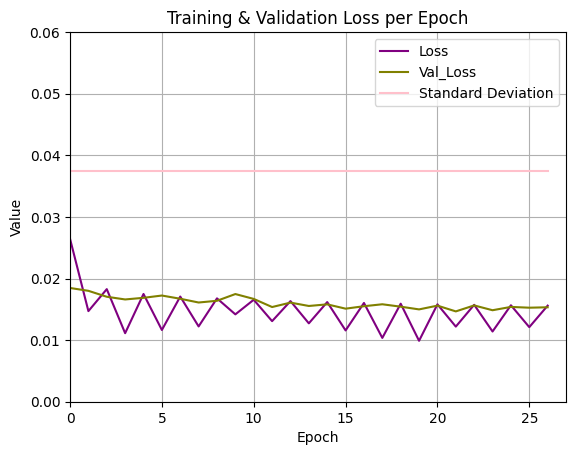

In [17]:
s=[df_Scaled.std()]*len(history.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history.history['loss'],  color='purple',label='Loss')
plt.plot(history.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model.png',format='png')
# Muestra el gráfico
plt.show()

In [18]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict = model.predict(test_dataset,steps=len(y_test))

/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))
W0000 00:00:1729576746.773513    1152 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729576746.824981    1152 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729576746.828356    1152 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729576746.837184    1152 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729576746.844243    1152 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729576746.847508    1152 gpu_timer.cc:114] Skipping the delay kerne

   26/20706 ━━━━━━━━━━━━━━━━━━━━ 2:07 6ms/step

W0000 00:00:1729576747.244936    1152 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729576747.245432    1152 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729576747.245943    1152 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step


In [19]:
# Calcular MAE
mae0 = mean_absolute_error(y_test, predict)
mse0= mean_squared_error(y_test, predict)
# Calcular R-squared
r20= r2_score(y_test, predict)


smape0 = smape_2(y_test, predict)

# Imprimir las métricas
print(f"MAE: {mae0}")
print(f"MSE: {mse0}")
print(f"R-squared: {r20}")
print(f"SMAPE: {smape0}%")

MAE: 0.015372138843604048
MSE: 0.0006837013516892901
R-squared: 0.46937094844786165
SMAPE: 27.971200154439767%


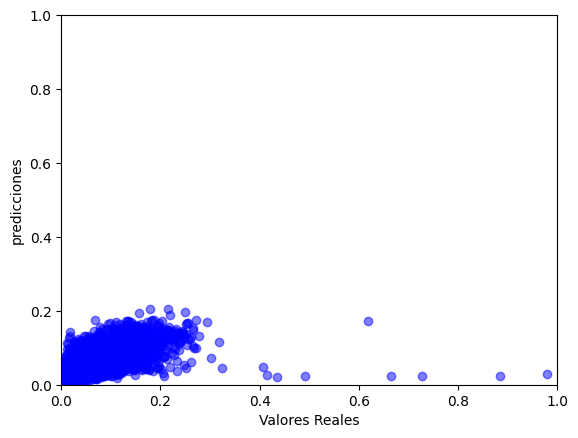

In [20]:
plt.scatter(y_test, predict, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [21]:
df['mp10'].describe()

count    151917.000000
mean         55.948889
std          34.322277
min           0.000000
25%          34.208300
50%          49.000000
75%          69.833300
max         917.940000
Name: mp10, dtype: float64

/tmp/ipykernel_1017/4037668646.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict[a]))


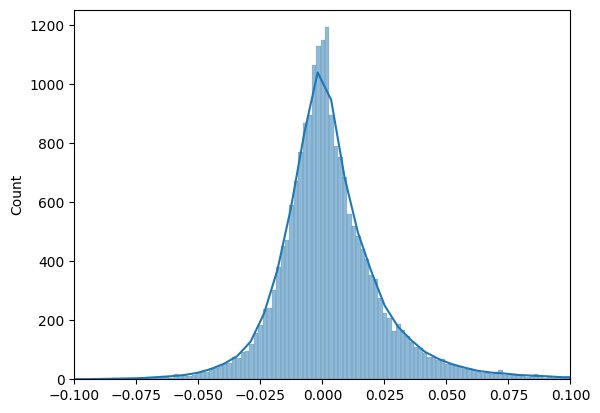

In [22]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 7 días para predecir promedio semanal siguiente (Sin capping)

In [23]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [24]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model1 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model1.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        880 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_4 │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_5 │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_6 │ (None, 26, 26,    │          0 │ conv2d_6[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_7 │ (None, 12, 12,    │          0 │ conv2d_7[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    589,952 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 7, 50)     │     13,600 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50)        │     20,200 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 178)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     22,912 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [26]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_1/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [27]:
history1=model1.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_19', 'keras_tensor_31']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0943 - mean_absolute_percentage_error: 17344.5430 - mean_squared_error: 0.7853 - smape: 47.9608
Epoch 1: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 499s 220ms/step - loss: 0.0943 - mean_absolute_percentage_error: 17345.0820 - mean_squared_error: 0.7850 - smape: 47.9590 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 24418.7715 - val_mean_squared_error: 7.4326e-04 - val_smape: 41.8283
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 3:48 101ms/step - loss: 0.0141 - mean_absolute_percentage_error: 22.6503 - mean_squared_error: 3.2109e-04 - smape: 31.7923
Epoch 2: saving model to training_1/ckpt.weights.h5


2024-10-22 03:10:19.054981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 03:10:19.055701: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 03:10:19.055713: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 03:10:19.055719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 03:10:19.055724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 03:10:19.055729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 03:10:19.055884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - loss: 0.0141 - mean_absolute_percentage_error: 22.6503 - mean_squared_error: 3.2109e-04 - smape: 15.9032 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 20.0021 - val_mean_squared_error: 5.3737e-04 - val_smape: 17.4291
Epoch 3/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0186 - mean_absolute_percentage_error: 17547.5625 - mean_squared_error: 7.9786e-04 - smape: 43.6004
Epoch 3: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 506s 224ms/step - loss: 0.0186 - mean_absolute_percentage_error: 17548.0840 - mean_squared_error: 7.9786e-04 - smape: 43.6005 - val_loss: 0.0171 - val_mean_absolute_percentage_error: 24772.9980 - val_mean_squared_error: 6.5913e-04 - val_smape: 43.8650
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 3:03 81ms/step - loss: 0.0092 - mean_absolute_percentage_error: 14.1510 - mean_squared_error: 1.4729e-04 - smape: 34.3661
Epoch 4: saving model to training_1/ckpt.weights.h5


2024-10-22 03:18:45.090985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 03:18:45.091409: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 03:18:45.091423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 03:18:45.091433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 03:18:45.091439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 03:18:45.091444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 03:18:45.091451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 116us/step - loss: 0.0092 - mean_absolute_percentage_error: 14.1510 - mean_squared_error: 1.4729e-04 - smape: 17.1907 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 19.1102 - val_mean_squared_error: 4.3562e-04 - val_smape: 17.4497
Epoch 5/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0180 - mean_absolute_percentage_error: 17318.5508 - mean_squared_error: 7.4877e-04 - smape: 44.1433
Epoch 5: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 500s 222ms/step - loss: 0.0180 - mean_absolute_percentage_error: 17319.0078 - mean_squared_error: 7.4877e-04 - smape: 44.1433 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 24430.9922 - val_mean_squared_error: 6.5571e-04 - val_smape: 45.2312
Epoch 6/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:17 61ms/step - loss: 0.0099 - mean_absolute_percentage_error: 14.8631 - mean_squared_error: 1.3990e-04 - smape: 33.2860
Epoch 6: saving model to training_1/ckpt.weights.h5
2253/225

2024-10-22 03:27:05.763731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 03:27:05.764087: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 03:27:05.764307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 03:27:05.764319: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 03:27:05.764326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 03:27:05.764331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 03:27:05.764340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0175 - mean_absolute_percentage_error: 17319.1582 - mean_squared_error: 7.2156e-04 - smape: 44.5153
Epoch 7: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 497s 220ms/step - loss: 0.0175 - mean_absolute_percentage_error: 17319.4805 - mean_squared_error: 7.2156e-04 - smape: 44.5153 - val_loss: 0.0163 - val_mean_absolute_percentage_error: 24664.0996 - val_mean_squared_error: 5.9930e-04 - val_smape: 46.3958
Epoch 8/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:18 62ms/step - loss: 0.0107 - mean_absolute_percentage_error: 16.9387 - mean_squared_error: 2.0043e-04 - smape: 37.7781
Epoch 8: saving model to training_1/ckpt.weights.h5


2024-10-22 03:35:23.424016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 03:35:23.424271: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 03:35:23.424293: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 03:35:23.424303: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 03:35:23.424311: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 03:35:23.424329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 03:35:23.424348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - loss: 0.0107 - mean_absolute_percentage_error: 16.9387 - mean_squared_error: 2.0043e-04 - smape: 18.8974 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 18.8317 - val_mean_squared_error: 4.1609e-04 - val_smape: 18.3719
Epoch 9/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0171 - mean_absolute_percentage_error: 16785.1094 - mean_squared_error: 6.9107e-04 - smape: 44.7076
Epoch 9: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 503s 223ms/step - loss: 0.0171 - mean_absolute_percentage_error: 16785.4590 - mean_squared_error: 6.9107e-04 - smape: 44.7076 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 23962.3867 - val_mean_squared_error: 6.1623e-04 - val_smape: 43.6794
Epoch 10/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:33 68ms/step - loss: 0.0081 - mean_absolute_percentage_error: 12.2180 - mean_squared_error: 1.0812e-04 - smape: 27.9281

2024-10-22 03:43:46.634507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 03:43:46.634874: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 03:43:46.634897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 03:43:46.634905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 03:43:46.634911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 03:43:46.634916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 03:43:46.634924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 10: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 140us/step - loss: 0.0081 - mean_absolute_percentage_error: 12.2180 - mean_squared_error: 1.0812e-04 - smape: 13.9703 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 18.4164 - val_mean_squared_error: 4.3295e-04 - val_smape: 17.5284
Epoch 11/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0168 - mean_absolute_percentage_error: 16969.2109 - mean_squared_error: 6.7416e-04 - smape: 44.9555
Epoch 11: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 501s 222ms/step - loss: 0.0168 - mean_absolute_percentage_error: 16969.5391 - mean_squared_error: 6.7416e-04 - smape: 44.9555 - val_loss: 0.0160 - val_mean_absolute_percentage_error: 22922.3848 - val_mean_squared_error: 5.8792e-04 - val_smape: 44.3299
Epoch 12/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:19 62ms/step - loss: 0.0083 - mean_absolute_percentage_error: 13.2186 - mean_squared_error: 1.1554e-04 - smape: 34.7555

2024-10-22 03:52:07.866603: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 03:52:07.867065: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 03:52:07.867085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 03:52:07.867097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 03:52:07.867106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 03:52:07.867114: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 03:52:07.867131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 12: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 155us/step - loss: 0.0083 - mean_absolute_percentage_error: 13.2186 - mean_squared_error: 1.1554e-04 - smape: 17.3854 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 18.8849 - val_mean_squared_error: 4.2486e-04 - val_smape: 17.4864
Epoch 13/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0165 - mean_absolute_percentage_error: 16234.6992 - mean_squared_error: 6.4853e-04 - smape: 45.2232
Epoch 13: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 503s 223ms/step - loss: 0.0165 - mean_absolute_percentage_error: 16235.0410 - mean_squared_error: 6.4854e-04 - smape: 45.2232 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 22548.4551 - val_mean_squared_error: 5.4733e-04 - val_smape: 45.4293
Epoch 14/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:44 73ms/step - loss: 0.0096 - mean_absolute_percentage_error: 15.4951 - mean_squared_error: 1.2367e-04 - smape: 27.8358

2024-10-22 04:00:31.761985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 04:00:31.762343: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 04:00:31.762541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 04:00:31.762555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 04:00:31.762562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 04:00:31.762568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 04:00:31.762578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 14: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 157us/step - loss: 0.0096 - mean_absolute_percentage_error: 15.4951 - mean_squared_error: 1.2367e-04 - smape: 13.9241 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 18.9915 - val_mean_squared_error: 3.8967e-04 - val_smape: 17.9923
Epoch 15/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0162 - mean_absolute_percentage_error: 15747.8906 - mean_squared_error: 6.3823e-04 - smape: 45.2782
Epoch 15: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 504s 223ms/step - loss: 0.0162 - mean_absolute_percentage_error: 15748.2988 - mean_squared_error: 6.3823e-04 - smape: 45.2782 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 22447.1484 - val_mean_squared_error: 5.5376e-04 - val_smape: 45.7264
Epoch 16/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 3:49 102ms/step - loss: 0.0095 - mean_absolute_percentage_error: 15.9310 - mean_squared_error: 1.3661e-04 - smape: 36.1219

2024-10-22 04:08:56.002779: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 04:08:56.003204: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 04:08:56.003236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 04:08:56.003244: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 04:08:56.003251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 04:08:56.003256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 04:08:56.003267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 16: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step - loss: 0.0095 - mean_absolute_percentage_error: 15.9310 - mean_squared_error: 1.3661e-04 - smape: 18.0690 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 19.0952 - val_mean_squared_error: 3.9453e-04 - val_smape: 18.2374
Epoch 17/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0159 - mean_absolute_percentage_error: 15450.8594 - mean_squared_error: 6.1920e-04 - smape: 45.5033
Epoch 17: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 505s 224ms/step - loss: 0.0159 - mean_absolute_percentage_error: 15451.4160 - mean_squared_error: 6.1921e-04 - smape: 45.5033 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 21063.8652 - val_mean_squared_error: 5.3917e-04 - val_smape: 47.2421
Epoch 18/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 3:34 95ms/step - loss: 0.0095 - mean_absolute_percentage_error: 13.5718 - mean_squared_error: 1.3271e-04 - smape: 34.0585
Epo

2024-10-22 04:17:21.114080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 04:17:21.114358: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 04:17:21.114552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 04:17:21.114567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 04:17:21.114578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 04:17:21.114584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 04:17:21.114772: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 124us/step - loss: 0.0095 - mean_absolute_percentage_error: 13.5718 - mean_squared_error: 1.3271e-04 - smape: 17.0368 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 18.8639 - val_mean_squared_error: 3.8160e-04 - val_smape: 18.6628
Epoch 19/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0158 - mean_absolute_percentage_error: 15326.9336 - mean_squared_error: 6.1053e-04 - smape: 45.5135
Epoch 19: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 502s 223ms/step - loss: 0.0158 - mean_absolute_percentage_error: 15327.2939 - mean_squared_error: 6.1053e-04 - smape: 45.5135 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 21174.6719 - val_mean_squared_error: 5.0883e-04 - val_smape: 46.6330
Epoch 20/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:29 66ms/step - loss: 0.0092 - mean_absolute_percentage_error: 13.5315 - mean_squared_error: 1.2738e-04 - smape: 31.7012

2024-10-22 04:25:43.967765: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 04:25:43.968359: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 04:25:43.968394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 04:25:43.968407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 04:25:43.968418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 04:25:43.968429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 04:25:43.968607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 20: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1s 219us/step - loss: 0.0092 - mean_absolute_percentage_error: 13.5315 - mean_squared_error: 1.2738e-04 - smape: 15.8576 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 17.2076 - val_mean_squared_error: 3.4447e-04 - val_smape: 18.4262
Epoch 21/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0157 - mean_absolute_percentage_error: 14547.8154 - mean_squared_error: 6.0624e-04 - smape: 45.6415
Epoch 21: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 503s 223ms/step - loss: 0.0157 - mean_absolute_percentage_error: 14548.3594 - mean_squared_error: 6.0624e-04 - smape: 45.6415 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 20600.3633 - val_mean_squared_error: 5.1133e-04 - val_smape: 47.7152
Epoch 22/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:19 62ms/step - loss: 0.0085 - mean_absolute_percentage_error: 13.8220 - mean_squared_error: 1.3959e-04 - smape: 37.0722
Epo

2024-10-22 04:34:07.304295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 04:34:07.305740: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 04:34:07.305778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 04:34:07.305788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 04:34:07.305796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 04:34:07.305804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 04:34:07.306003: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 112us/step - loss: 0.0085 - mean_absolute_percentage_error: 13.8220 - mean_squared_error: 1.3959e-04 - smape: 18.5443 - val_loss: 0.0140 - val_mean_absolute_percentage_error: 16.8104 - val_mean_squared_error: 3.5604e-04 - val_smape: 19.4942
Epoch 23/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0155 - mean_absolute_percentage_error: 15194.8105 - mean_squared_error: 6.0271e-04 - smape: 45.6558
Epoch 23: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 503s 223ms/step - loss: 0.0155 - mean_absolute_percentage_error: 15195.1182 - mean_squared_error: 6.0271e-04 - smape: 45.6558 - val_loss: 0.0145 - val_mean_absolute_percentage_error: 21372.7480 - val_mean_squared_error: 5.0740e-04 - val_smape: 45.8218
Epoch 24/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:36 69ms/step - loss: 0.0072 - mean_absolute_percentage_error: 11.0122 - mean_squared_error: 8.8266e-05 - smape: 33.3415
Epoch 24: saving model to training_1/ckpt.weights.h5


2024-10-22 04:42:30.326709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 04:42:30.327311: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16165363843285967717
2024-10-22 04:42:30.327368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 04:42:30.327415: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 04:42:30.327441: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 04:42:30.327449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - loss: 0.0072 - mean_absolute_percentage_error: 11.0122 - mean_squared_error: 8.8266e-05 - smape: 16.6781 - val_loss: 0.0142 - val_mean_absolute_percentage_error: 16.8890 - val_mean_squared_error: 3.7653e-04 - val_smape: 18.9717
Epoch 25/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0154 - mean_absolute_percentage_error: 14821.9395 - mean_squared_error: 5.9064e-04 - smape: 45.8081
Epoch 25: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 502s 221ms/step - loss: 0.0154 - mean_absolute_percentage_error: 14822.2080 - mean_squared_error: 5.9065e-04 - smape: 45.8081 - val_loss: 0.0144 - val_mean_absolute_percentage_error: 20793.8984 - val_mean_squared_error: 4.9622e-04 - val_smape: 46.9348


In [28]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

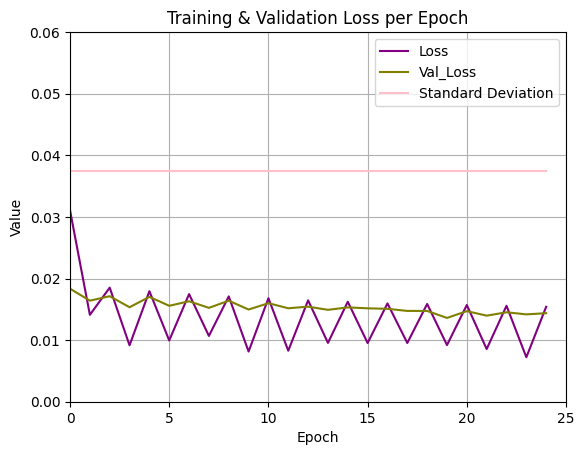

In [29]:
s=[df_Scaled.std()]*len(history1.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history1.history['loss'],  color='purple',label='Loss')
plt.plot(history1.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history1.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model1.png',format='png')
# Muestra el gráfico
plt.show()

In [30]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict1 = model1.predict(test_dataset,steps=len(y_test))

/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step


In [31]:
# Calcular MAE
mae1 = mean_absolute_error(y_test, predict1)
mse1= mean_squared_error(y_test, predict1)
# Calcular R-squared
r21 = r2_score(y_test, predict1)
smape1 = smape_2(y_test, predict1)

# Imprimir las métricas
print(f"MAE: {mae1}")
print(f"MSE: {mse1}")
print(f"R-squared: {r21}")
print(f"SMAPE: {smape1}%")

MAE: 0.01498561392263399
MSE: 0.0006343668376151745
R-squared: 0.5807892972568627
SMAPE: 20.32064262852426%


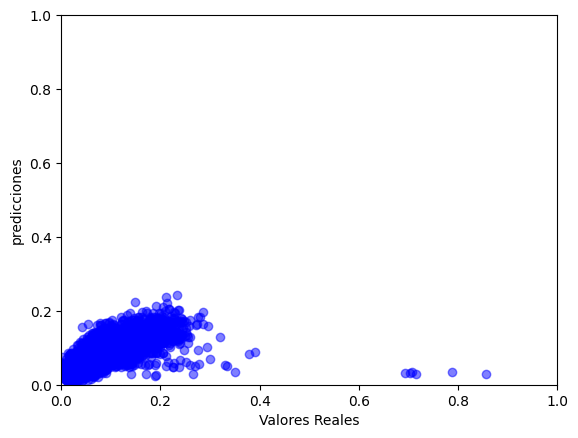

In [32]:
plt.scatter(y_test, predict1, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

/tmp/ipykernel_1017/101343474.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict1[a]))


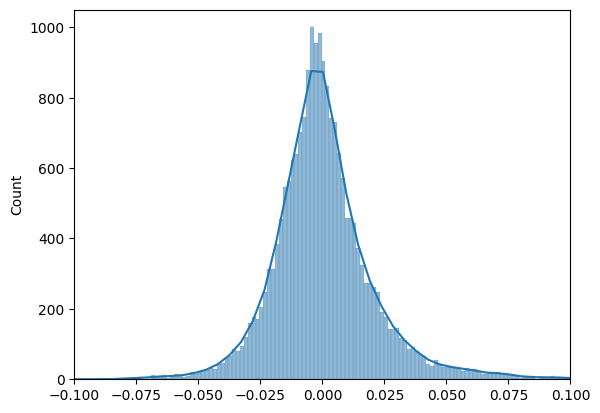

In [33]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict1[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el día siguiente (Sin capping)

In [34]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (123013, 10, 17), Forma de y: (123013, 1), Total de imágenes: (123013,)
Train set: X=(86109, 10, 17), y=(86109, 1), images=(86109,)
Test set: X=(24725, 10, 17), y=(24725, 1), images=(24725,)
Validation set: X=(12179, 10, 17), y=(12179, 1), images=(12179,)


In [35]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model2 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model2.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model2.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 222, 222,  │        880 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_8 │ (None, 111, 111,  │          0 │ conv2d_8[0][0]    │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_9 │ (None, 54, 54,    │          0 │ conv2d_9[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_10[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_11[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    589,952 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 10, 50)    │     13,600 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 50)        │     20,200 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 178)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     22,912 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [37]:
checkpoint_path = "training_2/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [38]:
history2=model2.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_38', 'keras_tensor_50']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1137 - mean_absolute_percentage_error: 1818477.5000 - mean_squared_error: 1.2110 - smape: 52.4823
Epoch 1: saving model to training_2/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 595s 220ms/step - loss: 0.1137 - mean_absolute_percentage_error: 1817913.7500 - mean_squared_error: 1.2106 - smape: 52.4810 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 57010.1641 - val_mean_squared_error: 7.9644e-04 - val_smape: 48.9912
Epoch 2/50


W0000 00:00:1729584218.451679    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584218.509847    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584218.526783    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584218.542433    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584218.557531    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584218.573822    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584218.602597    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584218.632707    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584218.649980    1153 gp

   1/2690 ━━━━━━━━━━━━━━━━━━━━ 47:38 1s/step - loss: 0.0188 - mean_absolute_percentage_error: 36.2826 - mean_squared_error: 6.4662e-04 - smape: 56.6192

W0000 00:00:1729584219.298053    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.299726    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.301442    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.303258    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.304694    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.306448    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.307946    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.309935    1153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.311691    1153 gp


Epoch 2: saving model to training_2/ckpt.weights.h5


W0000 00:00:1729584219.512350    1150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.513266    1150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.514173    1150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.515077    1150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.516119    1150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.517128    1150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.518216    1150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.519281    1150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729584219.520120    1150 gp

2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 138us/step - loss: 0.0188 - mean_absolute_percentage_error: 36.2826 - mean_squared_error: 6.4662e-04 - smape: 28.3201 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 58.2114 - val_mean_squared_error: 0.0014 - val_smape: 26.7766
Epoch 3/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0189 - mean_absolute_percentage_error: 73484.6562 - mean_squared_error: 8.6272e-04 - smape: 48.7071
Epoch 3: saving model to training_2/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 590s 219ms/step - loss: 0.0189 - mean_absolute_percentage_error: 73482.9219 - mean_squared_error: 8.6271e-04 - smape: 48.7073 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 55830.4727 - val_mean_squared_error: 7.0778e-04 - val_smape: 49.7331
Epoch 4/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:29 123ms/step - loss: 0.0173 - mean_absolute_percentage_error: 36.8889 - mean_squared_error: 4.7537e-04 - smape: 56.1950

2024-10-22 05:13:29.937782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 05:13:29.938385: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 05:13:29.938581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14260681515799792537
2024-10-22 05:13:29.938593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 05:13:29.938601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 05:13:29.938614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 05:13:29.938799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 4: saving model to training_2/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - loss: 0.0173 - mean_absolute_percentage_error: 36.8889 - mean_squared_error: 4.7537e-04 - smape: 28.1080 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 53.2129 - val_mean_squared_error: 0.0013 - val_smape: 24.9896
Epoch 5/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0178 - mean_absolute_percentage_error: 71912.2500 - mean_squared_error: 7.7752e-04 - smape: 49.4582
Epoch 5: saving model to training_2/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 597s 222ms/step - loss: 0.0178 - mean_absolute_percentage_error: 71910.1328 - mean_squared_error: 7.7751e-04 - smape: 49.4584 - val_loss: 0.0171 - val_mean_absolute_percentage_error: 53585.9297 - val_mean_squared_error: 6.7720e-04 - val_smape: 49.6640


In [39]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

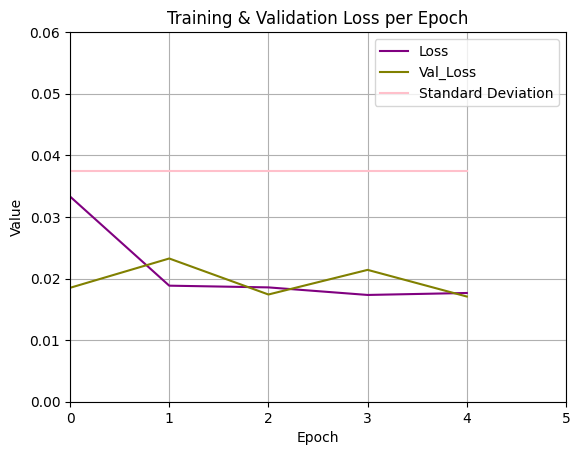

In [40]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*len(history2.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history2.history['loss'],  color='purple',label='Loss')
plt.plot(history2.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history2.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model2.png',format='png')
# Muestra el gráfico
plt.show()

In [41]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict2 = model2.predict(test_dataset,steps=len(y_test))

/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


24725/24725 ━━━━━━━━━━━━━━━━━━━━ 191s 8ms/step


In [42]:

mae2 = mean_absolute_error(y_test, predict2)
mse2= mean_squared_error(y_test, predict2)
r22 = r2_score(y_test, predict2)
smape2 = smape_2(y_test, predict2)

# Imprimir las métricas
print(f"MAE: {mae2}")
print(f"MSE: {mse2}")
print(f"R-squared: {r22}")
print(f"SMAPE: {smape2}%")

MAE: 0.01875389186867567
MSE: 0.000874299208566642
R-squared: 0.3092248013530351
SMAPE: 33.50996155928644%


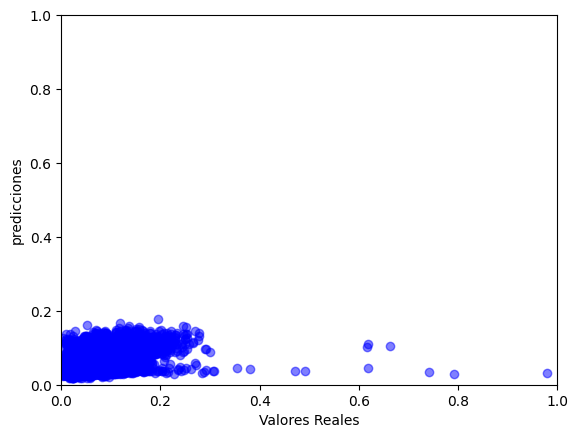

In [43]:
plt.scatter(y_test, predict2, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

/tmp/ipykernel_1017/1642356656.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict2[a]))


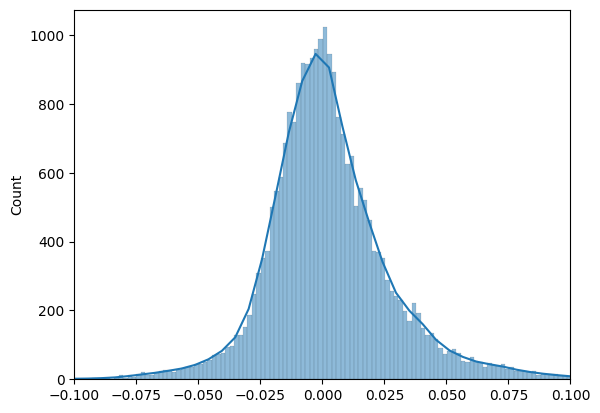

In [44]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict2[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el promedio de la semana siguiente (Sin capping)

In [45]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (123013, 10, 17), Forma de y: (123013, 1), Total de imágenes: (123013,)
Train set: X=(86109, 10, 17), y=(86109, 1), images=(86109,)
Test set: X=(24725, 10, 17), y=(24725, 1), images=(24725,)
Validation set: X=(12179, 10, 17), y=(12179, 1), images=(12179,)


In [46]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model3 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model3.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model3.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 222, 222,  │        880 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 111, 111,  │          0 │ conv2d_12[0][0]   │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 54, 54,    │          0 │ conv2d_13[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_14[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_15[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │    589,952 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 10, 50)    │     13,600 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 50)        │     20,200 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 178)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     22,912 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        129 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [48]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_3/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [49]:
history3=model3.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_57', 'keras_tensor_69']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.1484 - mean_absolute_percentage_error: 18707.1094 - mean_squared_error: 2.8626 - smape: 47.8252
Epoch 1: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 598s 221ms/step - loss: 0.1484 - mean_absolute_percentage_error: 18706.5703 - mean_squared_error: 2.8617 - smape: 47.8238 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 12152.9697 - val_mean_squared_error: 7.2244e-04 - val_smape: 46.6517
Epoch 2/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:47 107ms/step - loss: 0.0186 - mean_absolute_percentage_error: 23.3300 - mean_squared_error: 6.5911e-04 - smape: 51.5113
Epoch 2: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - loss: 0.0186 - mean_absolute_percentage_error: 23.3300 - mean_squared_error: 6.5911e-04 - smape: 25.7652 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 40.9876 - val_mean_squared_error: 0.0013 - val_smape: 25.1775
Epoch 3/50


2024-10-22 05:36:54.445492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 05:36:54.446558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8414759366606891301
2024-10-22 05:36:54.446571: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 05:36:54.446580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 05:36:54.446585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 05:36:54.446593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 05:36:54.446762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0182 - mean_absolute_percentage_error: 17452.3691 - mean_squared_error: 7.4323e-04 - smape: 43.6776
Epoch 3: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 588s 217ms/step - loss: 0.0182 - mean_absolute_percentage_error: 17452.1504 - mean_squared_error: 7.4323e-04 - smape: 43.6778 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 13237.6143 - val_mean_squared_error: 6.5815e-04 - val_smape: 47.1534
Epoch 4/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:57 111ms/step - loss: 0.0190 - mean_absolute_percentage_error: 25.0548 - mean_squared_error: 6.7517e-04 - smape: 52.5801

2024-10-22 05:46:42.926927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 05:46:42.927433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8414759366606891301
2024-10-22 05:46:42.927449: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 05:46:42.927459: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 05:46:42.927468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 05:46:42.927477: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 05:46:42.927650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 4: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 281us/step - loss: 0.0190 - mean_absolute_percentage_error: 25.0548 - mean_squared_error: 6.7517e-04 - smape: 26.2998 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 33.4601 - val_mean_squared_error: 8.4648e-04 - val_smape: 25.3195
Epoch 5/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0176 - mean_absolute_percentage_error: 18007.0684 - mean_squared_error: 6.9771e-04 - smape: 43.9931
Epoch 5: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 594s 221ms/step - loss: 0.0176 - mean_absolute_percentage_error: 18006.8477 - mean_squared_error: 6.9772e-04 - smape: 43.9933 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 13411.9248 - val_mean_squared_error: 6.3761e-04 - val_smape: 45.7862
Epoch 6/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 9:03 202ms/step - loss: 0.0202 - mean_absolute_percentage_error: 26.4864 - mean_squared_error: 6.7605e-04 - smape: 53.6650

2024-10-22 05:56:38.258341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 05:56:38.258762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8414759366606891301
2024-10-22 05:56:38.258780: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 05:56:38.258789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 05:56:38.258797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 05:56:38.258804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 05:56:38.259146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 6: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 199us/step - loss: 0.0202 - mean_absolute_percentage_error: 26.4864 - mean_squared_error: 6.7605e-04 - smape: 26.8425 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 31.9885 - val_mean_squared_error: 7.4226e-04 - val_smape: 24.8282
Epoch 7/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0170 - mean_absolute_percentage_error: 17404.1465 - mean_squared_error: 6.6174e-04 - smape: 44.3693
Epoch 7: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 597s 222ms/step - loss: 0.0170 - mean_absolute_percentage_error: 17404.0625 - mean_squared_error: 6.6175e-04 - smape: 44.3695 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 14177.3516 - val_mean_squared_error: 6.1817e-04 - val_smape: 43.4114
Epoch 8/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 8:54 199ms/step - loss: 0.0205 - mean_absolute_percentage_error: 28.3126 - mean_squared_error: 7.2129e-04 - smape: 48.4988

2024-10-22 06:06:35.819014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 06:06:35.819556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 06:06:35.819569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 06:06:35.819750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8414759366606891301
2024-10-22 06:06:35.819775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 06:06:35.819971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 06:06:35.819987: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send it


Epoch 8: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - loss: 0.0205 - mean_absolute_percentage_error: 28.3126 - mean_squared_error: 7.2129e-04 - smape: 24.2584 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 38.2776 - val_mean_squared_error: 6.9581e-04 - val_smape: 23.6174
Epoch 9/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0166 - mean_absolute_percentage_error: 18258.7344 - mean_squared_error: 6.3717e-04 - smape: 44.7373
Epoch 9: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 593s 220ms/step - loss: 0.0166 - mean_absolute_percentage_error: 18258.5020 - mean_squared_error: 6.3717e-04 - smape: 44.7375 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 13649.9473 - val_mean_squared_error: 5.8735e-04 - val_smape: 46.7372
Epoch 10/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:30 101ms/step - loss: 0.0163 - mean_absolute_percentage_error: 20.7930 - mean_squared_error: 5.7355e-04 - smape: 51.5692

2024-10-22 06:16:29.707788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 06:16:29.708059: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8414759366606891301
2024-10-22 06:16:29.708277: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 06:16:29.708315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 06:16:29.708352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 06:16:29.708390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 06:16:29.708429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 10: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step - loss: 0.0163 - mean_absolute_percentage_error: 20.7930 - mean_squared_error: 5.7355e-04 - smape: 25.7942 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 29.5805 - val_mean_squared_error: 4.7398e-04 - val_smape: 25.5056
Epoch 11/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0163 - mean_absolute_percentage_error: 17859.8906 - mean_squared_error: 6.1958e-04 - smape: 44.8798
Epoch 11: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 599s 223ms/step - loss: 0.0163 - mean_absolute_percentage_error: 17859.6328 - mean_squared_error: 6.1959e-04 - smape: 44.8799 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 14196.8076 - val_mean_squared_error: 5.8334e-04 - val_smape: 44.3092
Epoch 12/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 7:09 160ms/step - loss: 0.0165 - mean_absolute_percentage_error: 23.5149 - mean_squared_error: 4.7662e-04 - smape: 47.5608

2024-10-22 06:26:29.733792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 06:26:29.734539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8414759366606891301
2024-10-22 06:26:29.734551: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 06:26:29.734560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 06:26:29.734566: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 06:26:29.734573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 06:26:29.734743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 12: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step - loss: 0.0165 - mean_absolute_percentage_error: 23.5149 - mean_squared_error: 4.7662e-04 - smape: 23.7892 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 35.7353 - val_mean_squared_error: 5.3347e-04 - val_smape: 24.1303
Epoch 13/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0160 - mean_absolute_percentage_error: 17654.5273 - mean_squared_error: 6.0511e-04 - smape: 45.1069
Epoch 13: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 598s 222ms/step - loss: 0.0160 - mean_absolute_percentage_error: 17654.2188 - mean_squared_error: 6.0512e-04 - smape: 45.1071 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 13304.2656 - val_mean_squared_error: 5.9151e-04 - val_smape: 44.8675
Epoch 14/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 8:10 182ms/step - loss: 0.0139 - mean_absolute_percentage_error: 18.3009 - mean_squared_error: 4.2790e-04 - smape: 46.9554

2024-10-22 06:36:28.308159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 06:36:28.308880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 06:36:28.308895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 06:36:28.309237: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8414759366606891301
2024-10-22 06:36:28.309254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 06:36:28.309422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 06:36:28.309433: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send it


Epoch 14: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step - loss: 0.0139 - mean_absolute_percentage_error: 18.3009 - mean_squared_error: 4.2790e-04 - smape: 23.4864 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 38.4440 - val_mean_squared_error: 4.9887e-04 - val_smape: 23.9072
Epoch 15/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0158 - mean_absolute_percentage_error: 17114.2305 - mean_squared_error: 5.8923e-04 - smape: 45.1830
Epoch 15: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 595s 221ms/step - loss: 0.0158 - mean_absolute_percentage_error: 17114.0117 - mean_squared_error: 5.8924e-04 - smape: 45.1832 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 12765.2129 - val_mean_squared_error: 5.6003e-04 - val_smape: 46.2231


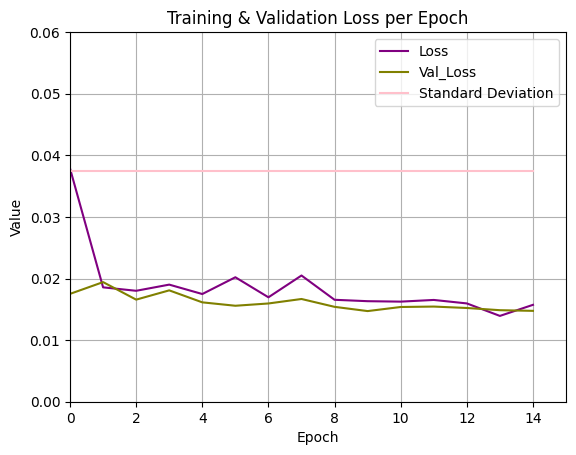

In [50]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()
s=[df_Scaled.std()]*len(history3.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history3.history['loss'],  color='purple',label='Loss')
plt.plot(history3.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history3.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model3.png',format='png')
# Muestra el gráfico
plt.show()

In [51]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict3 = model3.predict(test_dataset,steps=len(y_test))

/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


24725/24725 ━━━━━━━━━━━━━━━━━━━━ 196s 8ms/step


In [52]:
# Calcular MAE
mae3 = mean_absolute_error(y_test, predict3)
mse3= mean_squared_error(y_test, predict3)
# Calcular R-squared
r23 = r2_score(y_test, predict3)

smape3 = smape_2(y_test, predict3)

# Imprimir las métricas
print(f"MAE: {mae3}")
print(f"MSE: {mse3}")
print(f"R-squared: {r23}")
print(f"SMAPE: {smape3}%")

MAE: 0.015453120782262275
MSE: 0.0006440503920947557
R-squared: 0.5483808234564398
SMAPE: 21.672205208610347%


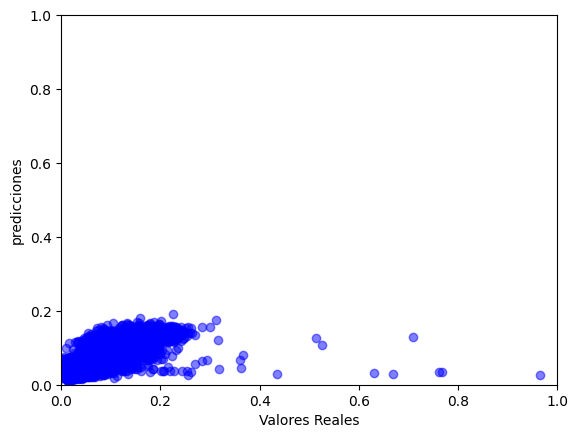

In [53]:
plt.scatter(y_test, predict3, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

/tmp/ipykernel_1017/2902670054.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict3[a]))


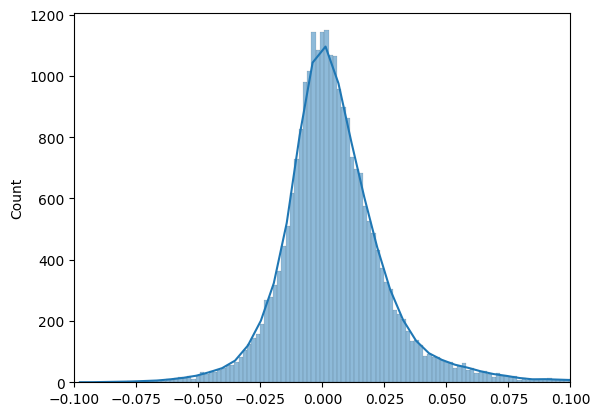

In [54]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict3[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 7 días para predecir día siguiente (Capping)

In [29]:
# Calcular la media y la desviación estándar
mean = df['mp10'].mean()
std = df['mp10'].std()

# Definir límites usando múltiplos de la desviación estándar (ej. 3 desviaciones estándar)
lower_cap = mean - 3 * std  # Límite inferior: media - 3 veces la desviación estándar
upper_cap = mean + 3 * std  # Límite superior: media + 3 veces la desviación estándar

# Aplicar el capping
df['mp10'] = df['mp10'].clip(lower=lower_cap, upper=upper_cap)

In [56]:
df['mp10'].describe()

count    151917.000000
mean         55.373795
std          31.277526
min           0.000000
25%          34.208300
50%          49.000000
75%          69.833300
max         158.915720
Name: mp10, dtype: float64

In [30]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [58]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model4 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model4.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model4.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 222, 222,  │        880 │ input_layer_8[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 111, 111,  │          0 │ conv2d_16[0][0]   │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 54, 54,    │          0 │ conv2d_17[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_18[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_19[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │    589,952 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 7, 50)     │     13,600 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 50)        │     20,200 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 178)       │          0 │ dropout_8[0][0],  │
│ (Concatenate)       │                   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     22,912 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │        129 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [60]:
checkpoint_path = "training_4/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [61]:
history4=model4.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)




Epoch 1/50


/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_76', 'keras_tensor_88']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1357 - mean_absolute_percentage_error: 362262.1562 - mean_squared_error: 2.4486 - smape: 52.5074
Epoch 1: saving model to training_4/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 508s 224ms/step - loss: 0.1357 - mean_absolute_percentage_error: 362156.7188 - mean_squared_error: 2.4477 - smape: 52.5057 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 97166.4922 - val_mean_squared_error: 9.1612e-04 - val_smape: 47.3461
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:48 75ms/step - loss: 0.0147 - mean_absolute_percentage_error: 25.0829 - mean_squared_error: 3.0375e-04 - smape: 38.8704
Epoch 2: saving model to training_4/ckpt.weights.h5


2024-10-22 06:58:25.938589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 06:58:25.939172: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 06:58:25.939388: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 06:58:25.939402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 06:58:25.939409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 06:58:25.939573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 06:58:25.939592: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 108us/step - loss: 0.0147 - mean_absolute_percentage_error: 25.0829 - mean_squared_error: 3.0375e-04 - smape: 19.4438 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 38.9988 - val_mean_squared_error: 5.2942e-04 - val_smape: 19.7952
Epoch 3/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0187 - mean_absolute_percentage_error: 59675.3086 - mean_squared_error: 8.6402e-04 - smape: 48.8467
Epoch 3: saving model to training_4/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 502s 223ms/step - loss: 0.0187 - mean_absolute_percentage_error: 59678.7812 - mean_squared_error: 8.6400e-04 - smape: 48.8467 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 91289.3984 - val_mean_squared_error: 8.3148e-04 - val_smape: 47.6890
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:37 70ms/step - loss: 0.0138 - mean_absolute_percentage_error: 20.5289 - mean_squared_error: 3.3737e-04 - smape: 41.7507

2024-10-22 07:06:48.575808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 07:06:48.576381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 07:06:48.576636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 07:06:48.576651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 07:06:48.576813: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 07:06:48.576827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 976823307045295768
2024-10-22 07:06:48.916557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite


Epoch 4: saving model to training_4/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step - loss: 0.0138 - mean_absolute_percentage_error: 20.5289 - mean_squared_error: 3.3737e-04 - smape: 20.8846 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 37.8147 - val_mean_squared_error: 5.4728e-04 - val_smape: 19.5554
Epoch 5/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0177 - mean_absolute_percentage_error: 58470.2188 - mean_squared_error: 7.6119e-04 - smape: 49.4688
Epoch 5: saving model to training_4/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 507s 225ms/step - loss: 0.0177 - mean_absolute_percentage_error: 58473.2539 - mean_squared_error: 7.6118e-04 - smape: 49.4688 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 90342.2500 - val_mean_squared_error: 7.8984e-04 - val_smape: 47.7771


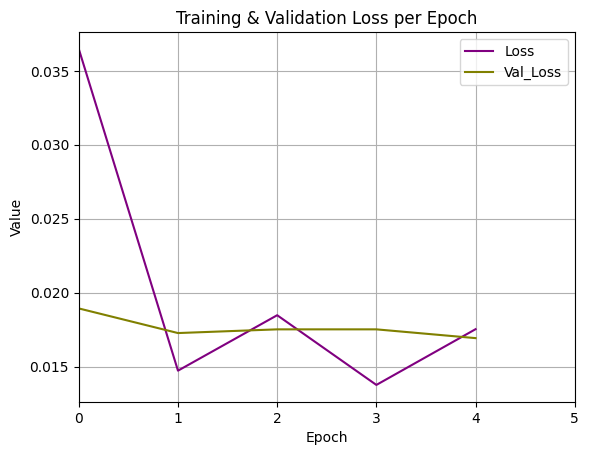

In [62]:
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history4.history['loss'],  color='purple',label='Loss')
plt.plot(history4.history['val_loss'],color='olive',label='Val_Loss')

# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history4.history['loss']))

plt.legend()

plt.grid(True)
# Muestra el gráfico
plt.show()

In [63]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict4 = model4.predict(test_dataset,steps=len(y_test))

/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step


In [64]:
# Calcular MAE
mae4 = mean_absolute_error(y_test, predict4)
mse4= mean_squared_error(y_test, predict4)
# Calcular R-squared
r24 = r2_score(y_test, predict4)
smape4 = smape_2(y_test, predict4)

# Imprimir las métricas
print(f"MAE: {mae4}")
print(f"MSE: {mse4}")
print(f"R-squared: {r24}")
print(f"SMAPE: {smape4}%")

MAE: 0.019055366506432244
MSE: 0.0009038789424198269
R-squared: 0.2984884046972761
SMAPE: 34.021328154287346%


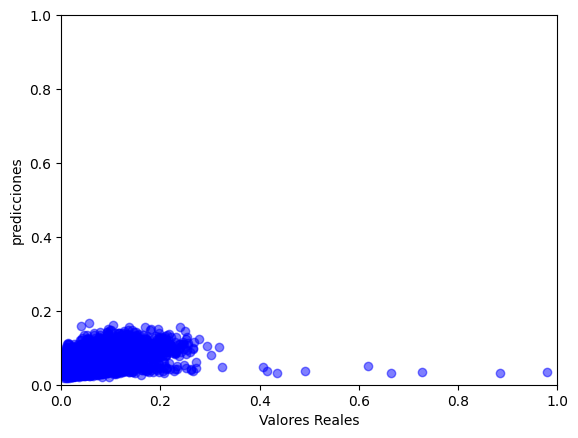

In [65]:
plt.scatter(y_test, predict4, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

/tmp/ipykernel_1017/950517328.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict4[a]))


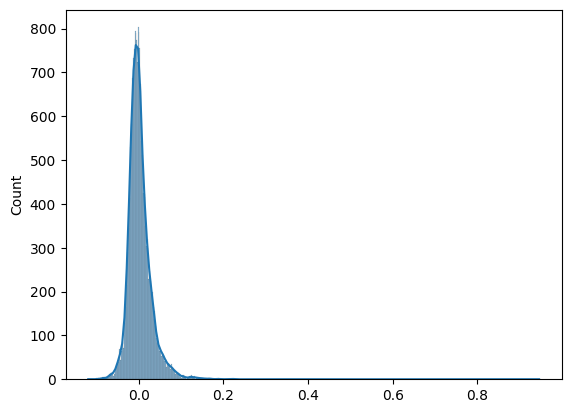

In [66]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict4[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.show()

### Usando 7 días para predecir día siguiente (Capping)

In [67]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [68]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model5 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model5.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model5.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 222, 222,  │        880 │ input_layer_10[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 111, 111,  │          0 │ conv2d_20[0][0]   │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 54, 54,    │          0 │ conv2d_21[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_22[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_23[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │    589,952 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 7, 50)     │     13,600 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 50)        │     20,200 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 178)       │          0 │ dropout_10[0][0], │
│ (Concatenate)       │                   │            │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     22,912 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [70]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_5/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [71]:
history5=model5.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

Epoch 1/50


/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_95', 'keras_tensor_107']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0813 - mean_absolute_percentage_error: 17653.7676 - mean_squared_error: 0.5874 - smape: 46.9245
Epoch 1: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 507s 223ms/step - loss: 0.0812 - mean_absolute_percentage_error: 17654.1777 - mean_squared_error: 0.5872 - smape: 46.9232 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 24381.3027 - val_mean_squared_error: 7.7260e-04 - val_smape: 46.0428
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:51 76ms/step - loss: 0.0130 - mean_absolute_percentage_error: 21.1204 - mean_squared_error: 2.5166e-04 - smape: 28.1823
Epoch 2: saving model to training_5/ckpt.weights.h5


2024-10-22 07:26:34.878869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 07:26:34.879632: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 07:26:34.879832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 07:26:34.879852: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 07:26:34.879859: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 07:26:34.880233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9183157338428709312
2024-10-22 07:26:34.880259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 101us/step - loss: 0.0130 - mean_absolute_percentage_error: 21.1204 - mean_squared_error: 2.5166e-04 - smape: 14.0974 - val_loss: 0.0178 - val_mean_absolute_percentage_error: 21.1332 - val_mean_squared_error: 5.8621e-04 - val_smape: 19.2401
Epoch 3/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0186 - mean_absolute_percentage_error: 17284.1191 - mean_squared_error: 7.9281e-04 - smape: 43.8323
Epoch 3: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 504s 224ms/step - loss: 0.0186 - mean_absolute_percentage_error: 17284.5996 - mean_squared_error: 7.9281e-04 - smape: 43.8323 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 24782.0664 - val_mean_squared_error: 6.7596e-04 - val_smape: 45.5085
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:25 65ms/step - loss: 0.0101 - mean_absolute_percentage_error: 14.4868 - mean_squared_error: 2.0861e-04 - smape: 34.9385

2024-10-22 07:34:59.156418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 07:34:59.156901: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 07:34:59.156917: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 07:34:59.156924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 07:34:59.156930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 07:34:59.157120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9183157338428709312
2024-10-22 07:34:59.157335: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 4: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - loss: 0.0101 - mean_absolute_percentage_error: 14.4868 - mean_squared_error: 2.0861e-04 - smape: 17.4770 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 18.8715 - val_mean_squared_error: 4.7120e-04 - val_smape: 18.2724
Epoch 5/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0180 - mean_absolute_percentage_error: 17289.4082 - mean_squared_error: 7.5488e-04 - smape: 44.1779
Epoch 5: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 506s 224ms/step - loss: 0.0180 - mean_absolute_percentage_error: 17289.9492 - mean_squared_error: 7.5488e-04 - smape: 44.1780 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 24498.3516 - val_mean_squared_error: 6.4766e-04 - val_smape: 44.4743
Epoch 6/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:29 67ms/step - loss: 0.0131 - mean_absolute_percentage_error: 20.7094 - mean_squared_error: 2.0755e-04 - smape: 35.5128

2024-10-22 07:43:26.117396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 07:43:26.117653: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 07:43:26.117670: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 07:43:26.117680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 07:43:26.117687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 07:43:26.117861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9183157338428709312
2024-10-22 07:43:26.117881: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 6: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1s 333us/step - loss: 0.0131 - mean_absolute_percentage_error: 20.7094 - mean_squared_error: 2.0755e-04 - smape: 17.7643 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 21.5855 - val_mean_squared_error: 5.2380e-04 - val_smape: 18.2084
Epoch 7/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0175 - mean_absolute_percentage_error: 17348.0781 - mean_squared_error: 7.1821e-04 - smape: 44.5552
Epoch 7: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 504s 224ms/step - loss: 0.0175 - mean_absolute_percentage_error: 17348.5879 - mean_squared_error: 7.1821e-04 - smape: 44.5552 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 23635.4395 - val_mean_squared_error: 6.2834e-04 - val_smape: 44.7444
Epoch 8/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 3:49 102ms/step - loss: 0.0111 - mean_absolute_percentage_error: 17.7784 - mean_squared_error: 1.6817e-04 - smape: 36.2803

2024-10-22 07:51:50.998711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 07:51:50.999299: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 07:51:50.999315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 07:51:50.999322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 07:51:50.999328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 07:51:50.999692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9183157338428709312
2024-10-22 07:51:50.999708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 8: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step - loss: 0.0111 - mean_absolute_percentage_error: 17.7784 - mean_squared_error: 1.6817e-04 - smape: 18.1482 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 21.4288 - val_mean_squared_error: 5.5461e-04 - val_smape: 18.0237
Epoch 9/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0171 - mean_absolute_percentage_error: 17070.1660 - mean_squared_error: 6.9463e-04 - smape: 44.7516
Epoch 9: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 512s 227ms/step - loss: 0.0171 - mean_absolute_percentage_error: 17070.6836 - mean_squared_error: 6.9463e-04 - smape: 44.7517 - val_loss: 0.0160 - val_mean_absolute_percentage_error: 24960.5723 - val_mean_squared_error: 5.7726e-04 - val_smape: 43.9774


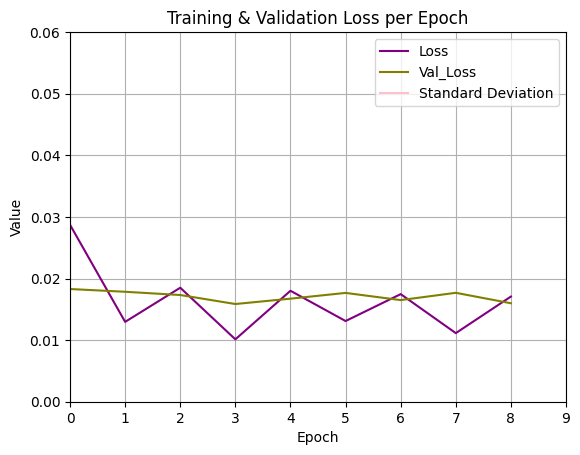

In [72]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*30
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history5.history['loss'],  color='purple',label='Loss')
plt.plot(history5.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history5.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model5.png',format='png')
# Muestra el gráfico
plt.show()

In [73]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict5 = model5.predict(test_dataset,steps=len(y_test))

/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 160s 8ms/step


In [74]:
# Calcular MAE
mae5 = mean_absolute_error(y_test, predict5)
mse5= mean_squared_error(y_test, predict5)
# Calcular R-squared
r25 = r2_score(y_test, predict5)
smape5 = smape_2(y_test, predict5)

# Imprimir las métricas
print(f"MAE: {mae5}")
print(f"MSE: {mse5}")
print(f"R-squared: {r25}")
print(f"SMAPE: {smape5}%")

MAE: 0.01746686467118573
MSE: 0.000800846779337525
R-squared: 0.4707738153246249
SMAPE: 24.034565254632174%


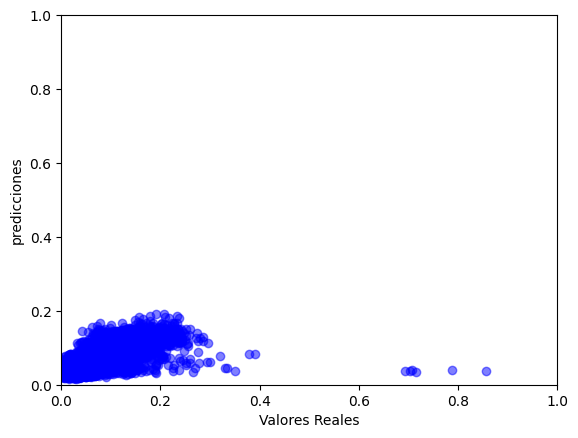

In [75]:
plt.scatter(y_test, predict5, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

/tmp/ipykernel_1017/918445844.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict5[a]))


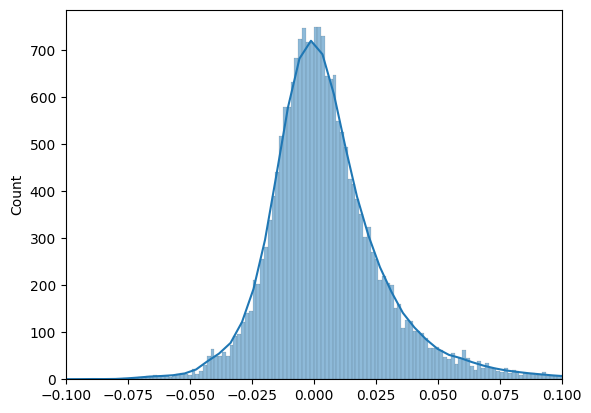

In [76]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict5[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el día siguiente (Capping)

In [77]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (123013, 10, 17), Forma de y: (123013, 1), Total de imágenes: (123013,)
Train set: X=(86109, 10, 17), y=(86109, 1), images=(86109,)
Test set: X=(24725, 10, 17), y=(24725, 1), images=(24725,)
Validation set: X=(12179, 10, 17), y=(12179, 1), images=(12179,)


In [78]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model6 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model6.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model6.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 222, 222,  │        880 │ input_layer_12[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 111, 111,  │          0 │ conv2d_24[0][0]   │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 54, 54,    │          0 │ conv2d_25[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_26[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_27[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │    589,952 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 10, 50)    │     13,600 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 50)        │     20,200 │ lstm_12[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 178)       │          0 │ dropout_12[0][0], │
│ (Concatenate)       │                   │            │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     22,912 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [80]:
checkpoint_path = "training_6/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [81]:
history6=model6.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_114', 'keras_tensor_126']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.1210 - mean_absolute_percentage_error: 167771.0938 - mean_squared_error: 1.9018 - smape: 52.2474
Epoch 1: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 591s 218ms/step - loss: 0.1209 - mean_absolute_percentage_error: 167738.1094 - mean_squared_error: 1.9012 - smape: 52.2463 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 54659.8750 - val_mean_squared_error: 7.8904e-04 - val_smape: 48.6677
Epoch 2/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 10:29 234ms/step - loss: 0.0198 - mean_absolute_percentage_error: 35.4956 - mean_squared_error: 8.4441e-04 - smape: 56.6637

2024-10-22 08:13:12.191931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 08:13:12.192757: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 08:13:12.192970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7797065821305696953
2024-10-22 08:13:12.192990: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 08:13:12.192997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 08:13:12.193003: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 08:13:12.193560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 2: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 121us/step - loss: 0.0198 - mean_absolute_percentage_error: 35.4956 - mean_squared_error: 8.4441e-04 - smape: 28.3424 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 52.9430 - val_mean_squared_error: 0.0013 - val_smape: 25.9365
Epoch 3/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0187 - mean_absolute_percentage_error: 72609.9219 - mean_squared_error: 8.3786e-04 - smape: 48.9436
Epoch 3: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 593s 220ms/step - loss: 0.0187 - mean_absolute_percentage_error: 72607.9453 - mean_squared_error: 8.3785e-04 - smape: 48.9438 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 54042.4961 - val_mean_squared_error: 6.8761e-04 - val_smape: 49.8559
Epoch 4/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:06 114ms/step - loss: 0.0165 - mean_absolute_percentage_error: 32.0975 - mean_squared_error: 4.9586e-04 - smape: 58.9590

2024-10-22 08:23:05.497120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 08:23:05.497750: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 08:23:05.498182: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7797065821305696953
2024-10-22 08:23:05.498202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 08:23:05.498210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 08:23:05.498217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 08:23:05.498231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 4: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 223us/step - loss: 0.0165 - mean_absolute_percentage_error: 32.0975 - mean_squared_error: 4.9586e-04 - smape: 29.4905 - val_loss: 0.0229 - val_mean_absolute_percentage_error: 59.5113 - val_mean_squared_error: 0.0012 - val_smape: 25.0675
Epoch 5/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0176 - mean_absolute_percentage_error: 70225.1484 - mean_squared_error: 7.6457e-04 - smape: 49.9097
Epoch 5: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 593s 220ms/step - loss: 0.0176 - mean_absolute_percentage_error: 70223.1719 - mean_squared_error: 7.6456e-04 - smape: 49.9098 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 54958.3086 - val_mean_squared_error: 6.6011e-04 - val_smape: 49.5945


In [82]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()


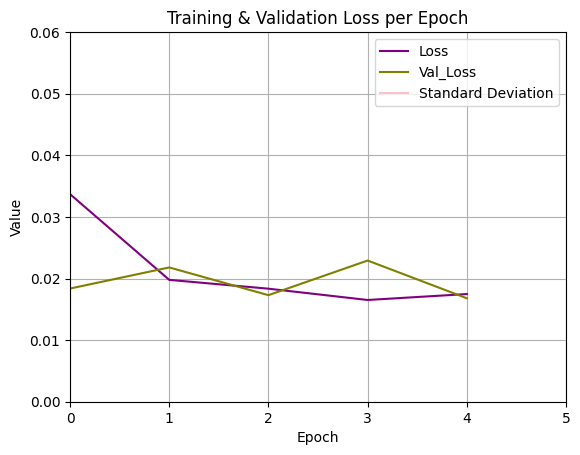

In [83]:
s=[df_Scaled.std()]*len(history6.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history6.history['loss'],  color='purple',label='Loss')
plt.plot(history6.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history6.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model6.png',format='png')
# Muestra el gráfico
plt.show()

In [84]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict6 = model6.predict(test_dataset,steps=len(y_test))

/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


24725/24725 ━━━━━━━━━━━━━━━━━━━━ 194s 8ms/step


In [85]:
mae6 = mean_absolute_error(y_test, predict6)
mse6= mean_squared_error(y_test, predict6)
# Calcular R-squared
r26 = r2_score(y_test, predict6)

smape6 = smape_2(y_test, predict6)

# Imprimir las métricas
print(f"MAE: {mae6}")
print(f"MSE: {mse6}")
print(f"R-squared: {r26}")
print(f"SMAPE: {smape6}%")

MAE: 0.018665548674043356
MSE: 0.000868867120436982
R-squared: 0.3135166407142824
SMAPE: 33.303442816594746%


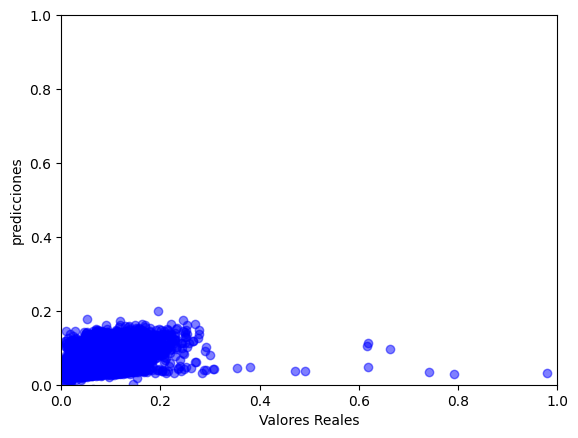

In [86]:
plt.scatter(y_test, predict6, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

/tmp/ipykernel_1017/2528644800.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict6[a]))


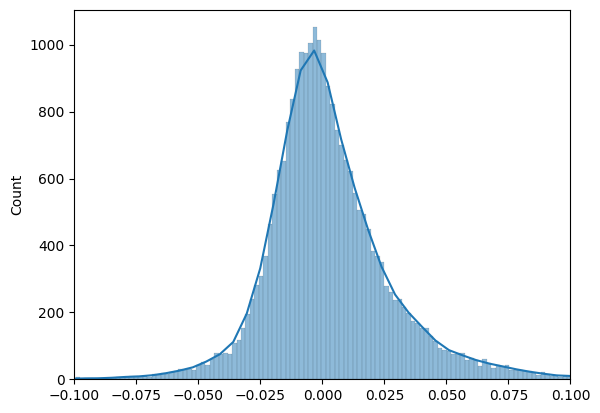

In [87]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict6[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el promedio de la semana siguiente (Capping)

In [88]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (123013, 10, 17), Forma de y: (123013, 1), Total de imágenes: (123013,)
Train set: X=(86109, 10, 17), y=(86109, 1), images=(86109,)
Test set: X=(24725, 10, 17), y=(24725, 1), images=(24725,)
Validation set: X=(12179, 10, 17), y=(12179, 1), images=(12179,)


In [89]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model7 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model7.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model7.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 222, 222,  │        880 │ input_layer_14[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 111, 111,  │          0 │ conv2d_28[0][0]   │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 54, 54,    │          0 │ conv2d_29[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_30[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_31[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │    589,952 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 10, 50)    │     13,600 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 50)        │     20,200 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 178)       │          0 │ dropout_14[0][0], │
│ (Concatenate)       │                   │            │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 128)       │     22,912 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [91]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_7/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [92]:
history7=model7.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_133', 'keras_tensor_145']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0762 - mean_absolute_percentage_error: 15933.6016 - mean_squared_error: 0.6113 - smape: 46.2628
Epoch 1: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 594s 218ms/step - loss: 0.0762 - mean_absolute_percentage_error: 15933.8594 - mean_squared_error: 0.6111 - smape: 46.2619 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 14192.6816 - val_mean_squared_error: 6.7599e-04 - val_smape: 44.1351
Epoch 2/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 7:52 176ms/step - loss: 0.0191 - mean_absolute_percentage_error: 27.1101 - mean_squared_error: 6.9012e-04 - smape: 46.5153
Epoch 2: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 79us/step - loss: 0.0191 - mean_absolute_percentage_error: 27.1101 - mean_squared_error: 6.9012e-04 - smape: 23.2663 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 45.1286 - val_mean_squared_error: 0.0011 - val_smape: 23.8824
Epoch 3/50


2024-10-22 08:46:28.586931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 08:46:28.587910: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 08:46:28.588131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 08:46:28.588144: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 08:46:28.588152: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 08:46:28.588475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 08:46:28.588490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0181 - mean_absolute_percentage_error: 17077.5801 - mean_squared_error: 7.3294e-04 - smape: 43.6758
Epoch 3: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 600s 223ms/step - loss: 0.0181 - mean_absolute_percentage_error: 17077.5352 - mean_squared_error: 7.3294e-04 - smape: 43.6760 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 14184.4551 - val_mean_squared_error: 6.8024e-04 - val_smape: 44.8815
Epoch 4/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:39 126ms/step - loss: 0.0183 - mean_absolute_percentage_error: 23.2826 - mean_squared_error: 6.9545e-04 - smape: 48.2994

2024-10-22 08:56:29.229907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 08:56:29.230197: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 08:56:29.230417: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 08:56:29.230430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 08:56:29.230439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 08:56:29.230457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 08:56:29.230465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i


Epoch 4: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 143us/step - loss: 0.0183 - mean_absolute_percentage_error: 23.2826 - mean_squared_error: 6.9545e-04 - smape: 24.1587 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 34.0760 - val_mean_squared_error: 9.4659e-04 - val_smape: 24.4078
Epoch 5/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0174 - mean_absolute_percentage_error: 17841.5508 - mean_squared_error: 6.9892e-04 - smape: 44.1262
Epoch 5: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 593s 220ms/step - loss: 0.0174 - mean_absolute_percentage_error: 17841.3359 - mean_squared_error: 6.9893e-04 - smape: 44.1264 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 12962.9668 - val_mean_squared_error: 6.5182e-04 - val_smape: 45.1356
Epoch 6/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:59 134ms/step - loss: 0.0203 - mean_absolute_percentage_error: 24.5727 - mean_squared_error: 8.2569e-04 - smape: 48.6232

2024-10-22 09:06:22.535575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 09:06:22.535894: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 09:06:22.536118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 09:06:22.536130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 09:06:22.536271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 09:06:22.536285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14919744312016287262
2024-10-22 09:06:22.640525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i


Epoch 6: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 157us/step - loss: 0.0203 - mean_absolute_percentage_error: 24.5727 - mean_squared_error: 8.2569e-04 - smape: 24.3207 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 32.4407 - val_mean_squared_error: 6.6857e-04 - val_smape: 24.5102
Epoch 7/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0168 - mean_absolute_percentage_error: 17354.6934 - mean_squared_error: 6.4696e-04 - smape: 44.5858
Epoch 7: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 599s 222ms/step - loss: 0.0168 - mean_absolute_percentage_error: 17354.5176 - mean_squared_error: 6.4696e-04 - smape: 44.5859 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 13762.2148 - val_mean_squared_error: 5.9776e-04 - val_smape: 46.1162
Epoch 8/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 7:45 173ms/step - loss: 0.0176 - mean_absolute_percentage_error: 20.9362 - mean_squared_error: 6.4211e-04 - smape: 47.0757

2024-10-22 09:16:21.741008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 09:16:21.741446: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 09:16:21.741660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 09:16:21.741672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 09:16:21.741679: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 09:16:21.741828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 09:16:21.741841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i


Epoch 8: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 141us/step - loss: 0.0176 - mean_absolute_percentage_error: 20.9362 - mean_squared_error: 6.4211e-04 - smape: 23.5466 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 31.8831 - val_mean_squared_error: 5.8185e-04 - val_smape: 24.9474
Epoch 9/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0164 - mean_absolute_percentage_error: 17218.0605 - mean_squared_error: 6.2569e-04 - smape: 44.8100
Epoch 9: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 591s 220ms/step - loss: 0.0164 - mean_absolute_percentage_error: 17217.8242 - mean_squared_error: 6.2570e-04 - smape: 44.8101 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 13768.0908 - val_mean_squared_error: 5.7703e-04 - val_smape: 44.6416
Epoch 10/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:33 124ms/step - loss: 0.0150 - mean_absolute_percentage_error: 19.0288 - mean_squared_error: 4.9292e-04 - smape: 48.2160

2024-10-22 09:26:13.091771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 09:26:13.092342: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 09:26:13.092576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 09:26:13.092594: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 09:26:13.092604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 09:26:13.092786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 09:26:13.092801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i


Epoch 10: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 148us/step - loss: 0.0150 - mean_absolute_percentage_error: 19.0288 - mean_squared_error: 4.9292e-04 - smape: 24.1169 - val_loss: 0.0140 - val_mean_absolute_percentage_error: 34.6950 - val_mean_squared_error: 3.7663e-04 - val_smape: 24.7865
Epoch 11/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0162 - mean_absolute_percentage_error: 16662.2266 - mean_squared_error: 6.1336e-04 - smape: 44.9721
Epoch 11: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 595s 221ms/step - loss: 0.0162 - mean_absolute_percentage_error: 16662.0508 - mean_squared_error: 6.1336e-04 - smape: 44.9723 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 13221.0527 - val_mean_squared_error: 6.0899e-04 - val_smape: 44.9762
Epoch 12/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:18 118ms/step - loss: 0.0163 - mean_absolute_percentage_error: 20.5104 - mean_squared_error: 5.9647e-04 - smape: 46.7488

2024-10-22 09:36:08.982791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 09:36:08.983039: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17938191831901866431
2024-10-22 09:36:08.983262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 09:36:08.983274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 09:36:08.983280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 09:36:08.983294: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 09:36:08.983300: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i


Epoch 12: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 160us/step - loss: 0.0163 - mean_absolute_percentage_error: 20.5104 - mean_squared_error: 5.9647e-04 - smape: 23.3831 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 32.6411 - val_mean_squared_error: 6.3193e-04 - val_smape: 24.6295
Epoch 13/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0159 - mean_absolute_percentage_error: 16470.6777 - mean_squared_error: 5.9456e-04 - smape: 44.9682
Epoch 13: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 592s 220ms/step - loss: 0.0159 - mean_absolute_percentage_error: 16470.4648 - mean_squared_error: 5.9457e-04 - smape: 44.9684 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 12883.7607 - val_mean_squared_error: 5.6707e-04 - val_smape: 45.0439
Epoch 14/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 10:15 229ms/step - loss: 0.0147 - mean_absolute_percentage_error: 19.4874 - mean_squared_error: 4.2144e-04 - smape: 47.6014

2024-10-22 09:46:01.609671: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6798541505990387951
2024-10-22 09:46:01.610225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16582176780254153909
2024-10-22 09:46:01.610241: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15563205907772311281
2024-10-22 09:46:01.610248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5047988257384453641
2024-10-22 09:46:01.610414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 921563124448941174
2024-10-22 09:46:01.610428: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14919744312016287262
2024-10-22 09:46:01.693821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i


Epoch 14: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 151us/step - loss: 0.0147 - mean_absolute_percentage_error: 19.4874 - mean_squared_error: 4.2144e-04 - smape: 23.8096 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 34.3712 - val_mean_squared_error: 5.0955e-04 - val_smape: 24.6069
Epoch 15/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0157 - mean_absolute_percentage_error: 15925.5625 - mean_squared_error: 5.8482e-04 - smape: 45.2250
Epoch 15: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 595s 221ms/step - loss: 0.0157 - mean_absolute_percentage_error: 15925.4131 - mean_squared_error: 5.8483e-04 - smape: 45.2251 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 13991.6465 - val_mean_squared_error: 5.6992e-04 - val_smape: 44.5781


In [93]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

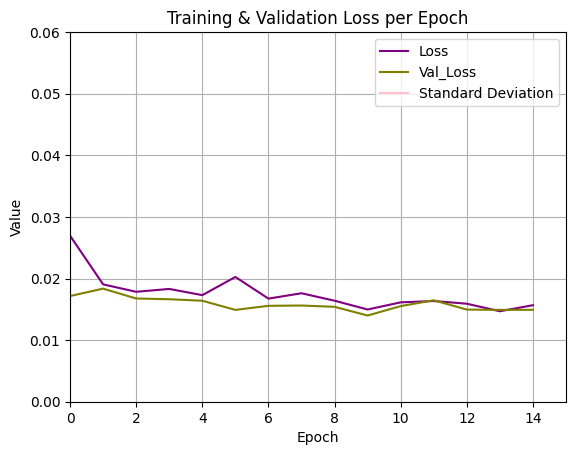

In [94]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*len(history7.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history7.history['loss'],  color='purple',label='Loss')
plt.plot(history7.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history7.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model7.png',format='png')
# Muestra el gráfico
plt.show()

In [95]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict7 = model7.predict(test_dataset,steps=len(y_test))

/tmp/ipykernel_1017/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


24725/24725 ━━━━━━━━━━━━━━━━━━━━ 197s 8ms/step


In [96]:
# Calcular MAE
mae7 = mean_absolute_error(y_test, predict7)
mse7= mean_squared_error(y_test, predict7)
# Calcular R-squared
r27 = r2_score(y_test, predict7)
smape7 = smape_2(y_test, predict7)

# Imprimir las métricas
print(f"MAE: {mae7}")
print(f"MSE: {mse7}")
print(f"R-squared: {r27}")
print(f"SMAPE: {smape7}%")

MAE: 0.01530273458823061
MSE: 0.0006265135118637618
R-squared: 0.5606779845268723
SMAPE: 21.37697633061122%


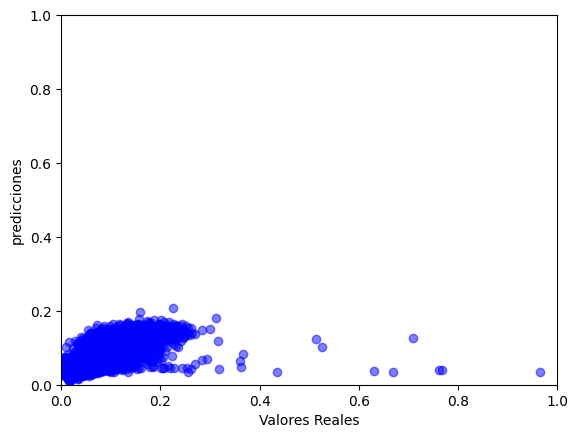

In [97]:
plt.scatter(y_test, predict7, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

/tmp/ipykernel_1017/3593836842.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict7[a]))


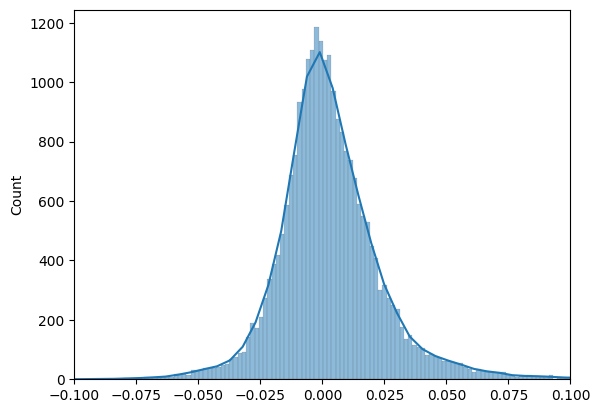

In [98]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict7[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

In [99]:
"""mae0=0.015121769530893035
mse0=0.0006718454255995287
r20=0.47857247891249843
smape0=27.390065786927174
mae1=0.015082720907047768
mse1=0.0006417234268826
r21=0.5759278184188708
smape1=20.28472924173946
mae2=0.014806741924627937
mse2=0.0006285826998406355
r22=0.5033629962214892
smape2=26.587521644042567
mae3=0.013352574654633033
mse3=0.0005326133697739282
r23=0.6265223739852904
smape3=18.46400621158139
mae4=0.018601448325700865
mse4=0.0009028183161912945
r24=0.2993115697945907
smape4=33.3972011408633
mae5=0.014784230964475288
mse5=0.000636672932877727
r25=0.5792653528160695
smape5=19.800282392672976
"""

'mae0=0.015121769530893035\nmse0=0.0006718454255995287\nr20=0.47857247891249843\nsmape0=27.390065786927174\nmae1=0.015082720907047768\nmse1=0.0006417234268826\nr21=0.5759278184188708\nsmape1=20.28472924173946\nmae2=0.014806741924627937\nmse2=0.0006285826998406355\nr22=0.5033629962214892\nsmape2=26.587521644042567\nmae3=0.013352574654633033\nmse3=0.0005326133697739282\nr23=0.6265223739852904\nsmape3=18.46400621158139\nmae4=0.018601448325700865\nmse4=0.0009028183161912945\nr24=0.2993115697945907\nsmape4=33.3972011408633\nmae5=0.014784230964475288\nmse5=0.000636672932877727\nr25=0.5792653528160695\nsmape5=19.800282392672976\n'

In [100]:
mae_list = [mae0, mae1, mae2, mae3, mae4, mae5, mae6, mae7]
mse_list = [mse0, mse1, mse2, mse3, mse4, mse5, mse6, mse7]
r2_list = [r20, r21, r22, r23, r24, r25, r26, r27]
smape_list = [smape0, smape1, smape2, smape3, smape4, smape5, smape6, smape7]

# Crear una lista de modelos del 0 al 7
modelos = list(range(8))

# Crear un diccionario con los datos
data = {
    'Modelo': modelos,
    'MAE': mae_list,
    'MSE': mse_list,
    'R2': r2_list,
    'SMAPE': smape_list
}

# Crear un DataFrame de pandas con los datos
dfs = pd.DataFrame(data)

# Mostrar el DataFrame
print(dfs)


   Modelo       MAE       MSE        R2      SMAPE
0       0  0.015372  0.000684  0.469371  27.971200
1       1  0.014986  0.000634  0.580789  20.320643
2       2  0.018754  0.000874  0.309225  33.509962
3       3  0.015453  0.000644  0.548381  21.672205
4       4  0.019055  0.000904  0.298488  34.021328
5       5  0.017467  0.000801  0.470774  24.034565
6       6  0.018666  0.000869  0.313517  33.303443
7       7  0.015303  0.000627  0.560678  21.376976


In [3]:
df1=pd.read_csv('trial1.csv')
df2=pd.read_csv('trial2.csv')
df3=pd.read_csv('trial3.csv')

In [7]:
df1.head()

,Modelo,MAE,MSE,R2,SMAPE
0,0,0.024951,0.001273,0.158933,36.601001
1,1,0.015039,0.000651,0.569825,20.962979
2,2,0.014962,0.000638,0.496238,26.880634
3,3,0.015112,0.000628,0.559664,21.026701
4,4,0.018601,0.000903,0.299312,33.397201


In [8]:
df2.head()

,Modelo,MAE,MSE,R2,SMAPE
0,0,0.015122,0.000672,0.478572,27.390066
1,1,0.015083,0.000642,0.575928,20.284729
2,2,0.014807,0.000629,0.503363,26.587522
3,3,0.013353,0.000533,0.626522,18.464006
4,4,0.015803,0.000704,0.453532,28.906742


In [9]:
df3.head()

,Modelo,MAE,MSE,R2,SMAPE
0,0,0.015372,0.000684,0.469371,27.971200
1,1,0.014986,0.000634,0.580789,20.320643
2,2,0.018754,0.000874,0.309225,33.509962
3,3,0.015453,0.000644,0.548381,21.672205
4,4,0.019055,0.000904,0.298488,34.021328


In [10]:
(0.024951+0.015122+0.015372)/3

0.018481666666666664

In [12]:
concatenated_df = pd.concat([df1, df2, df3])

# Calcular el promedio y la desviación estándar agrupando por el modelo
resultados_df = concatenated_df.groupby('Modelo').agg(['mean', 'std']).reset_index()

# Renombrar las columnas para mejor legibilidad
resultados_df.columns = ['Modelo', 'MAE_mean', 'MAE_std', 'MSE_mean', 'MSE_std', 'R2_mean', 'R2_std', 'SMAPE_mean', 'SMAPE_std']


# Ahora puedes ver los resultados con el promedio y la variación en notación científica
print(resultados_df)

   Modelo  MAE_mean   MAE_std  MSE_mean   MSE_std   R2_mean    R2_std  \
0       0  0.018482  0.005604  0.000876  0.000344  0.368959  0.181946   
1       1  0.015036  0.000049  0.000642  0.000008  0.575514  0.005494   
2       2  0.016174  0.002235  0.000713  0.000139  0.436275  0.110087   
3       3  0.014639  0.001127  0.000602  0.000060  0.578189  0.042236   
4       4  0.017820  0.001762  0.000837  0.000115  0.350444  0.089278   
5       5  0.016525  0.001509  0.000741  0.000091  0.510000  0.060161   
6       6  0.017401  0.002256  0.000786  0.000140  0.378758  0.110226   
7       7  0.015263  0.000351  0.000630  0.000016  0.557997  0.011390   

   SMAPE_mean  SMAPE_std  
0   30.654089   5.158367  
1   20.522784   0.381643  
2   28.992706   3.914803  
3   20.387637   1.696890  
4   32.108424   2.790243  
5   22.533608   2.370936  
6   31.080966   3.916936  
7   21.346964   0.472055  


In [28]:
# Filtrar modelos que no son 4, 5, 6, 7
modelos_a_transformar = resultados_df[~resultados_df['Modelo'].isin([4, 5, 6, 7])]

# Seleccionar columnas que serán transformadas (excluir SMAPE_mean y SMAPE_std)
columnas_a_transformar = ['MAE_mean', 'MAE_std', 'MSE_mean', 'MSE_std']

# Aplicar la transformación inversa usando scaler_y
modelos_a_transformar[columnas_a_transformar] = scaler_y.inverse_transform(modelos_a_transformar[columnas_a_transformar])

# Volver a combinar los modelos transformados con los no transformados
resultados_finales = pd.concat([modelos_a_transformar, resultados_df[resultados_df['Modelo'].isin([4, 5, 6, 7])]])

# Ordenar por Modelo para mantener el orden original
resultados_finales = resultados_finales.sort_values(by='Modelo').reset_index(drop=True)

# Mostrar los resultados finales
print(resultados_finales)


   Modelo   MAE_mean   MAE_std  MSE_mean   MSE_std   R2_mean    R2_std  \
0       0  16.965070  5.144230  0.804202  0.315362  0.368959  0.181946   
1       1  13.802004  0.044649  0.589638  0.007631  0.575514  0.005494   
2       2  14.846894  2.052029  0.654945  0.127901  0.436275  0.110087   
3       3  13.437878  1.034716  0.552179  0.055290  0.578189  0.042236   
4       4   0.017820  0.001762  0.000837  0.000115  0.350444  0.089278   
5       5   0.016525  0.001509  0.000741  0.000091  0.510000  0.060161   
6       6   0.017401  0.002256  0.000786  0.000140  0.378758  0.110226   
7       7   0.015263  0.000351  0.000630  0.000016  0.557997  0.011390   

   SMAPE_mean  SMAPE_std  
0   30.654089   5.158367  
1   20.522784   0.381643  
2   28.992706   3.914803  
3   20.387637   1.696890  
4   32.108424   2.790243  
5   22.533608   2.370936  
6   31.080966   3.916936  
7   21.346964   0.472055  


C:\Users\benja\AppData\Local\Temp\ipykernel_24040\969329627.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelos_a_transformar[columnas_a_transformar] = scaler_y.inverse_transform(modelos_a_transformar[columnas_a_transformar])


In [32]:
# Filtrar los modelos que no son 4, 5, 6, 7
modelos_a_transformar_y = resultados_df[~resultados_df['Modelo'].isin([4, 5, 6, 7])]

# Filtrar los modelos 4, 5, 6, 7
modelos_a_transformar_y2 = resultados_df[resultados_df['Modelo'].isin([4, 5, 6, 7])]

# Seleccionar columnas que serán transformadas (excluir SMAPE_mean y SMAPE_std)
columnas_a_transformar = ['MAE_mean', 'MAE_std', 'MSE_mean', 'MSE_std']

# Aplicar la transformación inversa con scaler_y a los modelos que no son 4 al 7
modelos_a_transformar_y[columnas_a_transformar] = scaler_y.inverse_transform(modelos_a_transformar_y[columnas_a_transformar])

# Aplicar la transformación inversa con scaler_y2 a los modelos 4, 5, 6, 7
modelos_a_transformar_y2[columnas_a_transformar] = scaler_y2.inverse_transform(modelos_a_transformar_y2[columnas_a_transformar])

# Combinar ambos conjuntos de datos
resultados_finales = pd.concat([modelos_a_transformar_y, modelos_a_transformar_y2])

# Ordenar por Modelo para mantener el orden original
resultados_finales = resultados_finales.sort_values(by='Modelo').reset_index(drop=True)

# Mostrar los resultados finales
print(resultados_finales)


   Modelo   MAE_mean   MAE_std  MSE_mean   MSE_std   R2_mean    R2_std  \
0       0  16.965070  5.144230  0.804202  0.315362  0.368959  0.181946   
1       1  13.802004  0.044649  0.589638  0.007631  0.575514  0.005494   
2       2  14.846894  2.052029  0.654945  0.127901  0.436275  0.110087   
3       3  13.437878  1.034716  0.552179  0.055290  0.578189  0.042236   
4       4  16.357491  1.617108  0.768256  0.105593  0.350444  0.089278   
5       5  15.168653  1.385153  0.680641  0.083567  0.510000  0.060161   
6       6  15.972806  2.070651  0.721769  0.128062  0.378758  0.110226   
7       7  14.010638  0.321945  0.578611  0.014910  0.557997  0.011390   

   SMAPE_mean  SMAPE_std  
0   30.654089   5.158367  
1   20.522784   0.381643  
2   28.992706   3.914803  
3   20.387637   1.696890  
4   32.108424   2.790243  
5   22.533608   2.370936  
6   31.080966   3.916936  
7   21.346964   0.472055  


C:\Users\benja\AppData\Local\Temp\ipykernel_24040\2707547793.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelos_a_transformar_y[columnas_a_transformar] = scaler_y.inverse_transform(modelos_a_transformar_y[columnas_a_transformar])
C:\Users\benja\AppData\Local\Temp\ipykernel_24040\2707547793.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelos_a_transformar_y2[columnas_a_transformar] = scaler_y2.inverse_transform(modelos_a_transformar_y2[columnas_a_transformar])
